In [1]:
import pandas as pd
import numpy as np
from equity_plot import equity_plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import compress
from scipy import stats
# import qgrid
import yfinance as yf
import datetime as dt
import time
from progressbar import *
from ipywidgets import interact
import random
import pandas_market_calendars as mcal
import bisect 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
# plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30

Data

In [2]:
stock_price = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_調整後股價資料\收盤價(元).csv")
stock_lend = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券\融券維持率.csv")
stock_lend_1 = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券\融資維持率.csv")
stock_market = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_借券餘額\市場別.csv")
stock_volume = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_調整後股價資料\成交值(千元).csv")
industry = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\industry.csv")

Time

In [3]:
bt_start = "2012-01-01"
bt_end = "2021-10-01"

Data

In [4]:
stock_df = stock_price.copy()
stock_df['年月日'] = pd.to_datetime(stock_df['年月日'].astype('str'))
stock_df = stock_df.set_index('年月日')
stock_df = stock_df.loc[bt_start:bt_end]

market_df = stock_market.copy()
market_df['年月日'] = pd.to_datetime(market_df['年月日'].astype('str'))
market_df = market_df.set_index('年月日')
market_df = market_df.loc[bt_start:bt_end]

volume_df = stock_volume.copy()
volume_df['年月日'] = pd.to_datetime(volume_df['年月日'].astype('str'))
volume_df = volume_df.set_index('年月日')
volume_df = volume_df.loc[bt_start:bt_end]

industry['公司簡稱'] = industry['公司簡稱'].astype(str)
industry_df = industry.copy()

In [5]:
def df_preprocess(factor_df,stock_df,market_df) : 
    
    df = factor_df.copy()
    df['年月日'] = pd.to_datetime(df['年月日'].astype('str'))
    df = df.set_index('年月日').dropna(axis = 1)
    df = df.loc[bt_start:bt_end].replace(['           -','      -','     -','              -','        -'],np.nan).dropna(axis = 1).astype('float')

    stock_set = set(stock_df.columns) & set(df.columns)&set(market_df.tail(1)[market_df.tail(1) == 'TSE  '].dropna(axis = 1).columns)
    stock_df = stock_df[list(stock_set)]
    df = df[list(stock_set)]
    stock_close = stock_df.copy()
    
    return df , stock_close, stock_set

In [6]:
def df_preprocess_re(factor_df,stock_df,market_df) : 
    
    df = factor_df.copy()
    df['年月日'] = pd.to_datetime(df['年月日'].astype('str'))
    df = df.set_index('年月日')
    df = df.loc[bt_start:bt_end].replace(['           -','      -','     -','              -','        -','            -'],np.nan).astype('float')

    stock_set = set(stock_df.columns) & set(df.columns)
    stock_df = stock_df[list(stock_set)]
    df = df[list(stock_set)]
    stock_close = stock_df.copy()
    
    return df , stock_close, stock_set

In [7]:
lend_df , stock_close ,stock_set= df_preprocess_re(stock_lend,stock_df,market_df)

Signal

In [8]:
signal_df = lend_df

Condition

In [16]:
def stock_signal(rebalance_day,cut_size,cut,data) :
    
    unlist_stock = market_df.loc[rebalance_list['end'][i-1]][market_df.loc[rebalance_list['end'][i-1]] == 'TSE  '].index
    df = pd.qcut(data.loc[rebalance_day,unlist_stock].dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut
    signal = df.keys()[df]
    return signal

In [63]:
def stock_multi_signal(rebalance_day,cut_size,cut1,cut2,data1,data2) :
    #data1 : 融資融券 pivot (main)
    #data2 : 股價報酬率 pivot   
    filter1 = stock_signal(rebalance_day,cut_size,cut1,data1)
    df = data2.loc[rebalance_day,filter1]
    df = pd.qcut(df.dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut2
    signal = df.keys()[df]
    return signal

In [58]:
def stock_signal_industry(rebalance_day,industry_set,cut_size,cut,data) :
    
    unlist_stock = market_df.loc[rebalance_list['end'][i-1]][market_df.loc[rebalance_list['end'][i-1]] == 'TSE  '].index
    unlist_stock = set(unlist_stock) & set(industry_set)
    df = pd.qcut(data.loc[rebalance_day,unlist_stock].dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut
    signal = df.keys()[df]
    return signal

In [68]:
def stock_multi_signal_industry(rebalance_day,industry_set,cut_size,cut1,cut2,data1,data2) :
    #data1 : 融資融券 pivot (main)
    #data2 : 股價報酬率 pivot   
    filter1 = stock_signal_industry(rebalance_day,industry_set,cut_size,cut,data1)
    df = data2.loc[rebalance_day,filter1]
    df = pd.qcut(df.dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut2
    signal = df.keys()[df]
    return signal

Rebalance Day

In [13]:
start_list = []
rebalance_day = 14
for x in range(len(stock_df.index)) :
    if x%rebalance_day == 0:
        start_list.append(stock_df.index[x])
        
end_list = []
for x in range(len(stock_df.index)-(rebalance_day-1)) :
    if x%rebalance_day == 0:
        end_list.append(stock_df.index[x+(rebalance_day-1)])


Backtest

In [14]:
rebalance_list = {'start' : start_list[:len(end_list)],'end' : end_list}
pd.DataFrame(rebalance_list)

start        end
0   2012-01-02 2012-01-30
1   2012-01-31 2012-02-16
2   2012-02-17 2012-03-08
3   2012-03-09 2012-03-28
4   2012-03-29 2012-04-18
..         ...        ...
165 2021-06-04 2021-06-24
166 2021-06-25 2021-07-14
167 2021-07-15 2021-08-03
168 2021-08-04 2021-08-23
169 2021-08-24 2021-09-10

[170 rows x 2 columns]

Factor Backtest

In [22]:
ret_long_list = []
ret_short_list = []
tic_long_list = []
tic_short_list = []
ret_port_list = []

long_cut = 1
short_cut = 5
cut_size = 5
cost = -0.001425

data1 = signal_df
# data1 = lend_df
# data2 = stock_df
# data3 = stock_21day_high

start_time = time.time()
for i in range(1,len(rebalance_list['start'])) :

    #     訊號
    long_signal = stock_signal(rebalance_list['end'][i-1],cut_size,long_cut,data1) 
    
    short_signal = stock_signal(rebalance_list['end'][i-1],cut_size,short_cut,data1) 
    #     回測
    ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

    ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

    ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

    tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

    ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

    tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns
    
    if long_signal.values.squeeze() != [] :
        ret_long[0] = cost
        ret_short[0] = cost
    
    ret_long_list.append(ret_long)
    tic_long_list.append(tic_long)
    
    ret_short_list.append(ret_short)
    tic_short_list.append(tic_short)
    
    ret_port_list.append((ret_long+ret_short)/2)

ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
tic_long_df = pd.DataFrame(tic_long_list)
ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
tic_short_df = pd.DataFrame(tic_short_list)
ret_port_df = (ret_long_df+ret_short_df)/2

end_time = time.time()
print('此次回測總共耗時 %f 秒' %(round(end_time-start_time,2)))

此次回測總共耗時 3.140000 秒


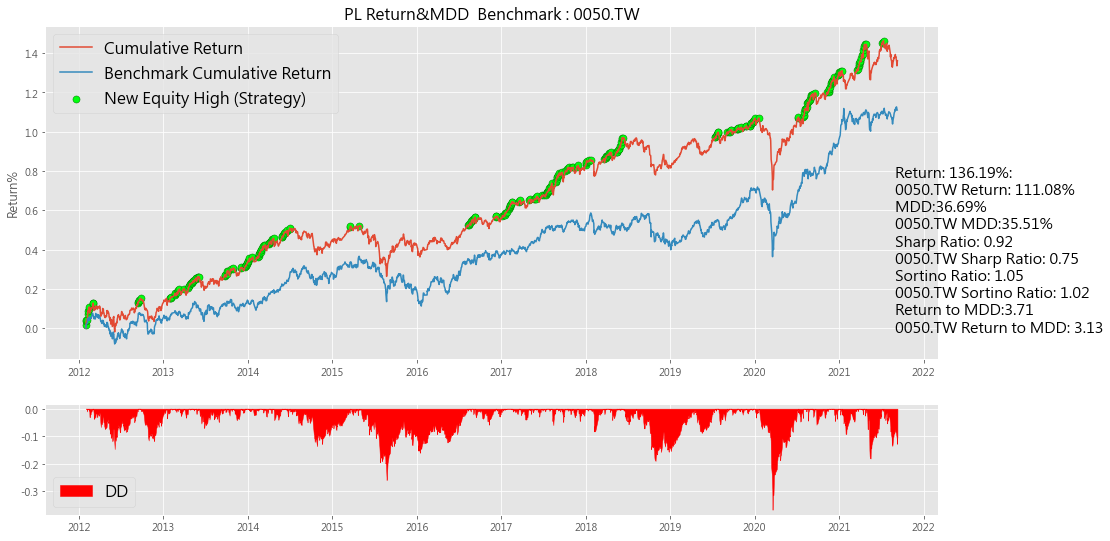

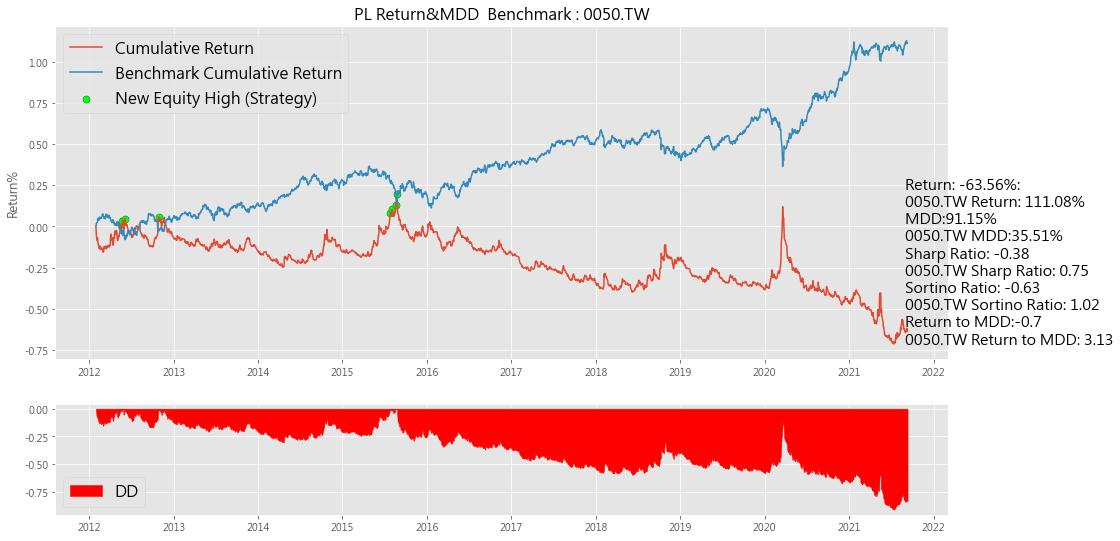

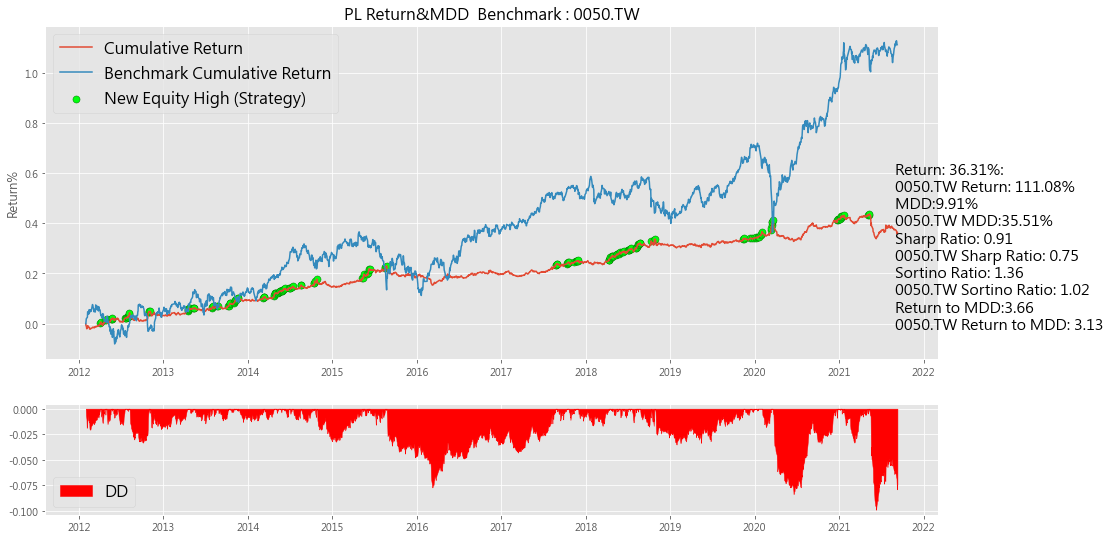

In [23]:
for i in [ret_long_df,ret_short_df,ret_port_df] :
    equity_plot(i.cumsum(),'0050.TW','PL',1)

挑選股票次數

<AxesSubplot:ylabel='value'>

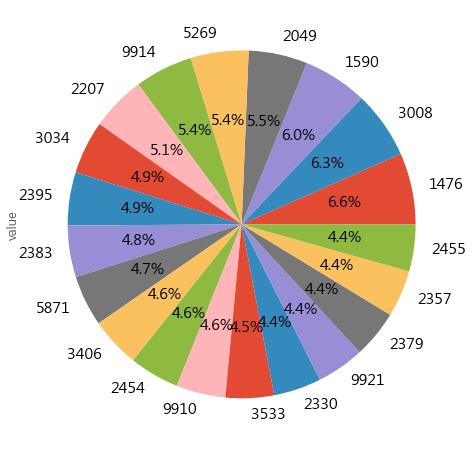

In [28]:
tic_long_df.melt().value.dropna().value_counts()[0:20].plot(kind = 'pie',figsize = (20,8),fontsize = 15,rot=0, autopct='%1.1f%%')

In [29]:
long_tick_df = tic_long_df.melt()
long_tick_df = long_tick_df.rename(columns = {"value":"公司簡稱"})
long_tick_df

variable  公司簡稱
0             0  1308
1             0  1303
2             0  1227
3             0  1232
4             0  1110
...         ...   ...
22979       135  None
22980       135  None
22981       135  None
22982       135  None
22983       135  None

[22984 rows x 2 columns]

In [30]:
long_tick_df = long_tick_df.merge(industry)

<AxesSubplot:ylabel='TSE新產業_名稱'>

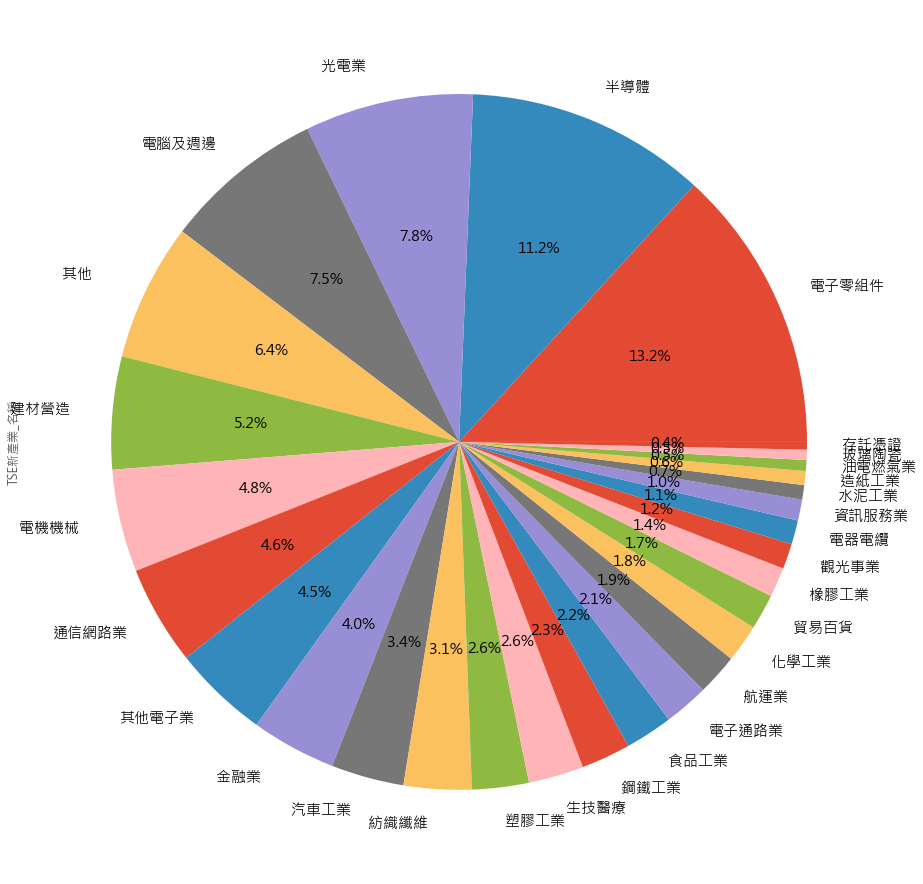

In [31]:
long_tick_df.TSE新產業_名稱.value_counts().plot(kind = 'pie',figsize = (40,16),fontsize = 15,rot=0, autopct='%1.1f%%')

因子分層

In [11]:
ret_dic = {}
cut_size = 5

In [18]:
for z in range(1,cut_size+1) :
    ret_long_list = []
    ret_short_list = []
    tic_long_list = []
    tic_short_list = []
    ret_port_list = []

    cut = z
    cost = -0.001425

    # data1 = signal_df
    data1 = signal_df
    # data2 = stock_df
    # data3 = stock_21day_high

    for i in range(1,len(rebalance_list['start'])) :
        
        long_signal = stock_signal(rebalance_list['end'][i-1],cut_size,cut,data1) & set(market_df.loc[rebalance_list['end'][i-1]][market_df.loc[rebalance_list['end'][i-1]] == 'TSE  '].index)
    
        ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

        tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns
        
        ret_long[0] = cost

        ret_long_list.append(ret_long)
        tic_long_list.append(tic_long)

        ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
        tic_long_df = pd.DataFrame(tic_long_list)
        
    ret_dic.setdefault(("cut_"+str(z)),ret_long_df)

In [19]:
ret_df = pd.DataFrame(ret_dic['cut_1'])
for i in range(2,cut_size+1) :
    df = ret_dic['cut_'+str(i)]
    ret_df = pd.concat([ret_df,df],axis = 1)
ret_df

0         0         0         0         0
年月日                                                         
2012-01-31 -0.001425 -0.001425 -0.001425 -0.001425 -0.001425
2012-02-01  0.016799  0.016516  0.026261  0.024579  0.030219
2012-02-02  0.018551  0.020950  0.019813  0.019263  0.021789
2012-02-03  0.006004  0.009255  0.010439  0.004935  0.010551
2012-02-04  0.003520  0.010788  0.010823  0.015365  0.020205
...              ...       ...       ...       ...       ...
2021-09-06 -0.019511 -0.015726 -0.012878 -0.013693 -0.011852
2021-09-07 -0.006839 -0.003752  0.001015 -0.002824  0.006609
2021-09-08 -0.020082 -0.017468 -0.015591 -0.012992 -0.012315
2021-09-09  0.016158  0.009713  0.007454  0.009426  0.009547
2021-09-10  0.009992  0.009931  0.006543  0.005999  0.006479

[2366 rows x 5 columns]

In [20]:
ret_df.columns = ['cut_'+str(i) for i in range(1,cut_size+1)]

<AxesSubplot:title={'center':'因子單調性'}, xlabel='年月日'>

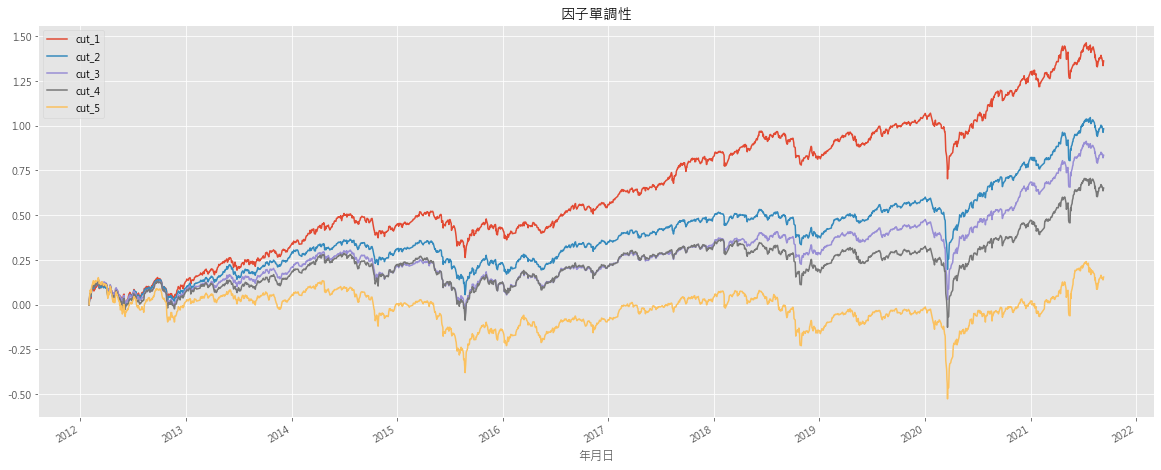

In [21]:
ret_df.cumsum().plot(figsize = (20,8), title = '因子單調性')

雙因子

In [32]:
ret_pct_df = stock_df.pct_change().rolling(14).std().fillna(0)
ret_pct_df

1101      1102      1103      1104  1107      1108      1109  \
年月日                                                                            
2012-01-02  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2012-01-03  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2012-01-04  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2012-01-05  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2012-01-06  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
...              ...       ...       ...       ...   ...       ...       ...   
2021-09-27  0.012275  0.013500  0.022745  0.008454   0.0  0.019393  0.028725   
2021-09-28  0.012347  0.013427  0.022628  0.007975   0.0  0.019102  0.028899   
2021-09-29  0.012658  0.013906  0.022765  0.008944   0.0  0.019102  0.029467   
2021-09-30  0.012565  0.013709  0.021943  0.008832   0.0  0.018182  0.028619   
2021-10-01  0.013308  0.013538  0.023702  0.009844   0.0  0.019226  0.029322   

                1110      1201      1203  1204  1207      1210  1212  \
年月日                                                                    
2012-01-02  0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
2012-01-03  0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
2012-01-04  0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
2012-01-05  0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
2012-01-06  0.000000  0.000000  0.000000   0.0   0.0  0.000000   0.0   
...              ...       ...       ...   ...   ...       ...   ...   
2021-09-27  0.037905  0.009028  0.007424   0.0   0.0  0.009009   0.0   
2021-09-28  0.039076  0.008372  0.007389   0.0   0.0  0.008527   0.0   
2021-09-29  0.044141  0.008857  0.007524   0.0   0.0  0.008896   0.0   
2021-09-30  0.047118  0.008748  0.007142   0.0   0.0  0.009031   0.0   
2021-10-01  0.048802  0.007939  0.007595   0.0   0.0  0.011163   0.0   

                1213      1215      1216      1217      1218      1219  \
年月日                                                                      
2012-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2021-09-27  0.014786  0.008635  0.009728  0.020836  0.010270  0.008191   
2021-09-28  0.014668  0.008945  0.010060  0.019769  0.010128  0.008173   
2021-09-29  0.014948  0.009570  0.009553  0.020149  0.010919  0.008767   
2021-09-30  0.014798  0.009496  0.009621  0.018635  0.010545  0.009146   
2021-10-01  0.014825  0.009923  0.009990  0.018713  0.010513  0.010485   

                1220  1224      1225      1227      1229      1231      1232  \
年月日                                                                            
2012-01-02  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-03  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-04  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-05  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-06  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...   ...       ...       ...       ...       ...       ...   
2021-09-27  0.008635   0.0  0.013896  0.005666  0.029521  0.010459  0.007293   
2021-09-28  0.008498   0.0  0.011262  0.005643  0.029522  0.009988  0.006723   
2021-09-29  0.008640   0.0  0.011635  0.006375  0.029381  0.010449  0.006458   
2021-09-30  0.007658   0.0  0.011667  0.006466  0.029550  0.009822  0.005957   
2021-10-01  0.008451   0.0  0.012714  0.006617  0.030307  0.010027  0.007399   

                1233      1234    

先融資在報酬率標準差

融券維持率top20%/報酬率標準差top20%


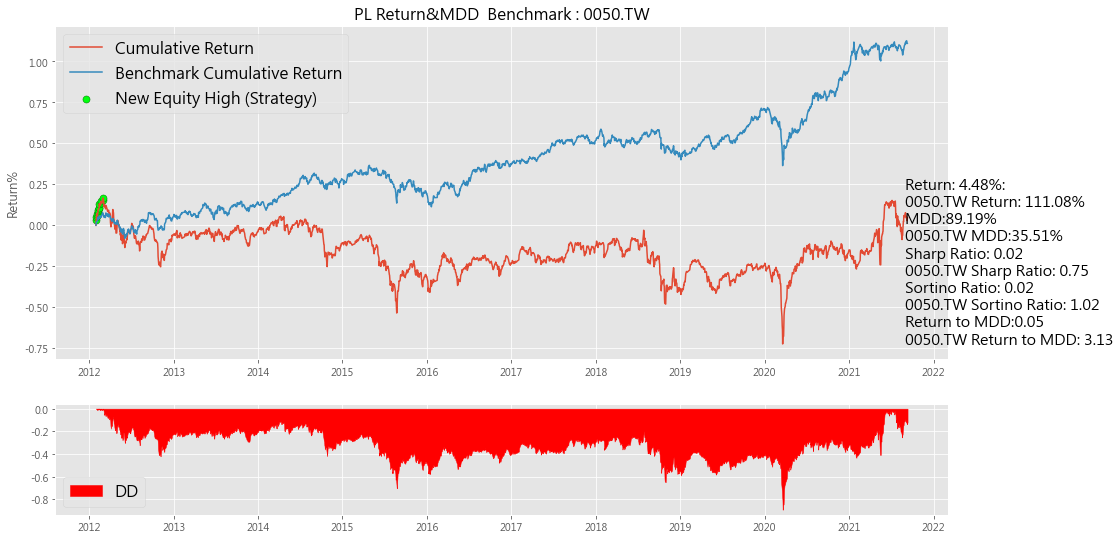

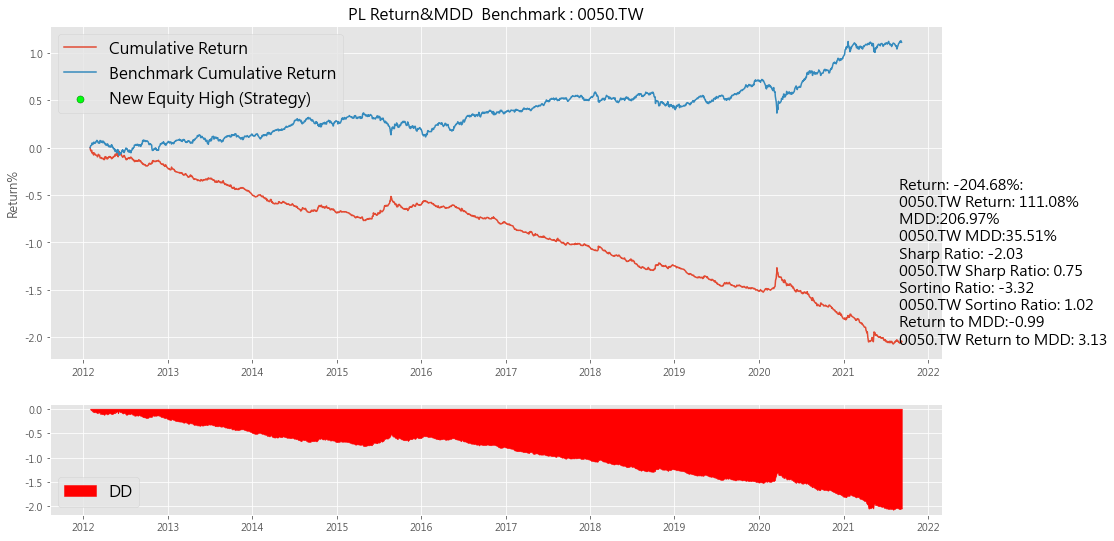

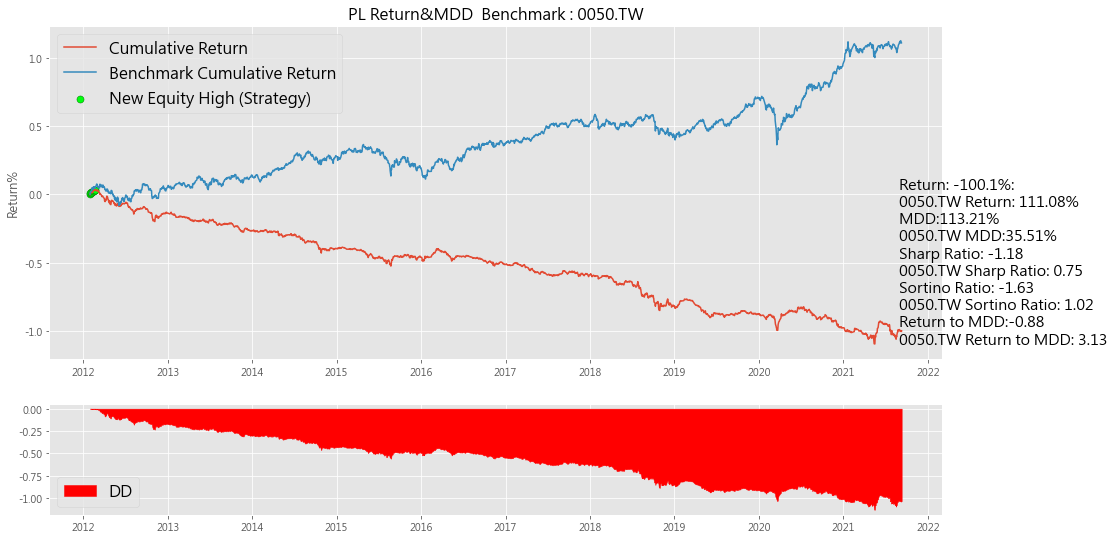

融券維持率top20%/報酬率標準差low20%


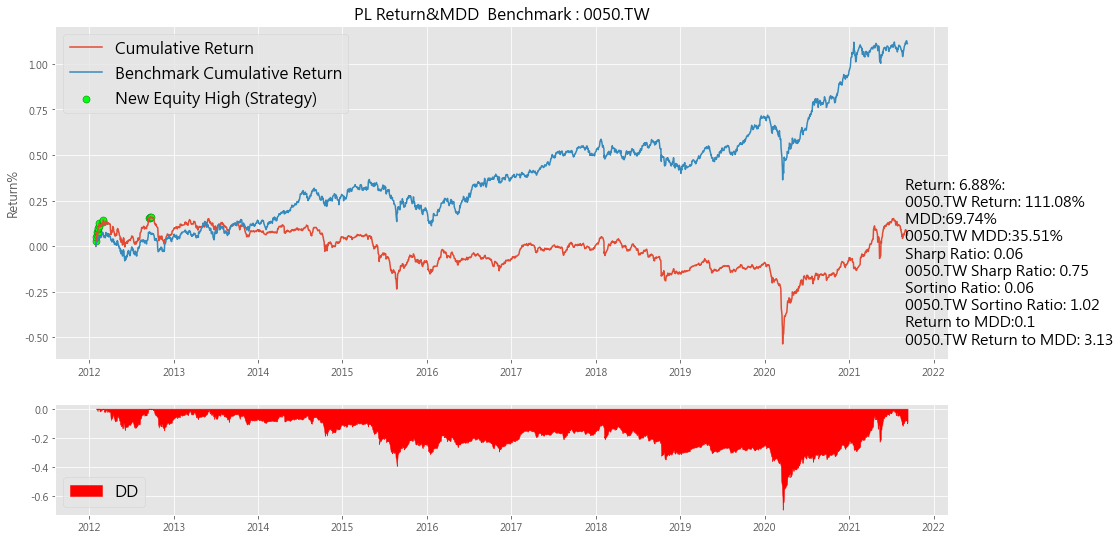

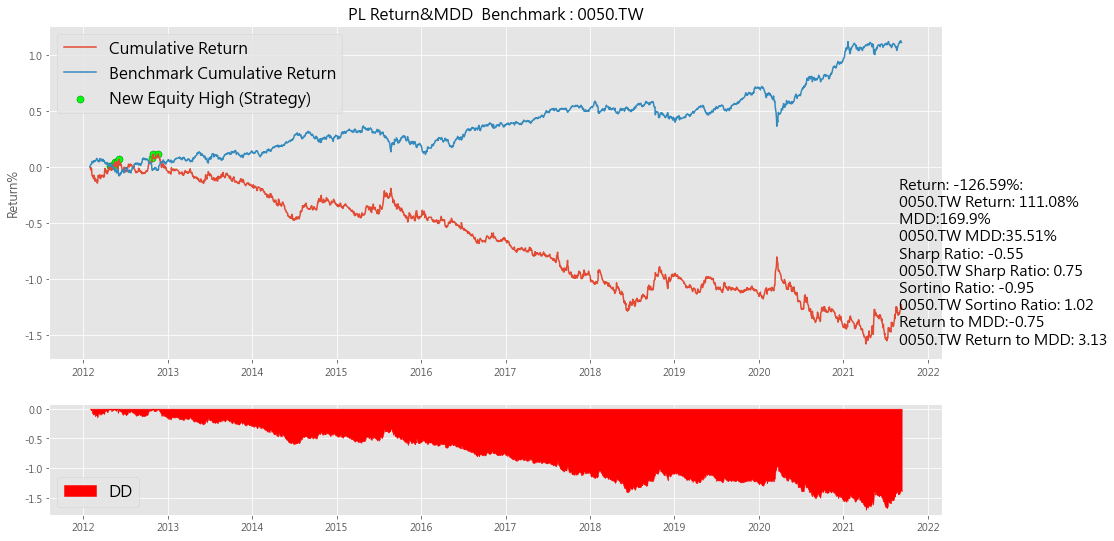

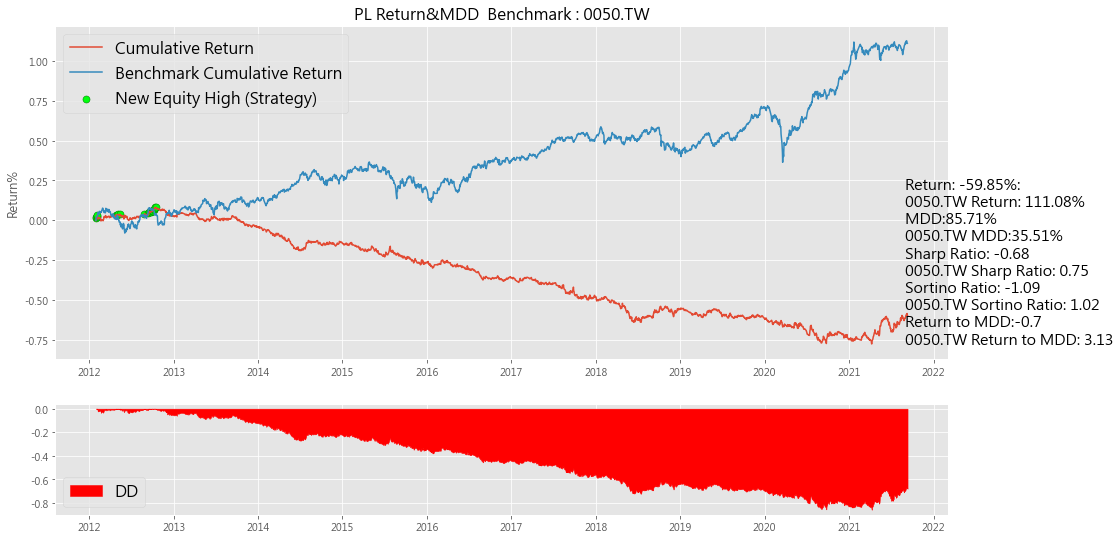

融券維持率low20%/報酬率標準差top20%


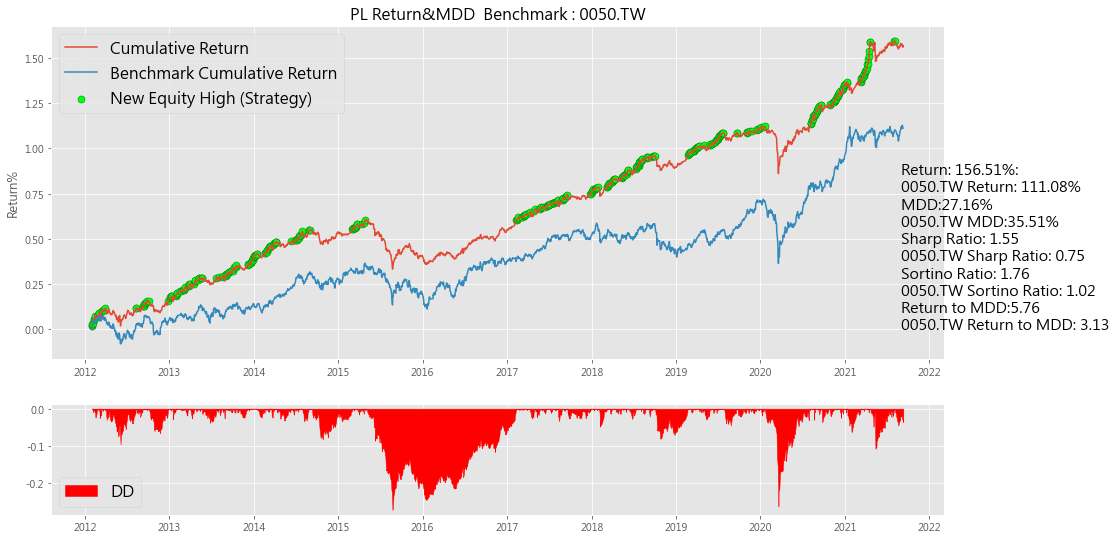

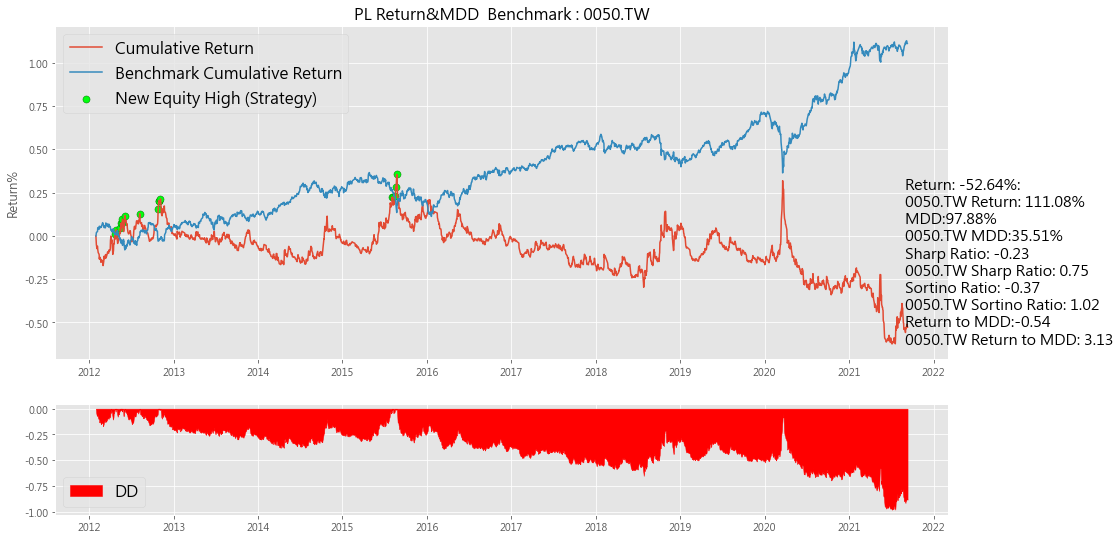

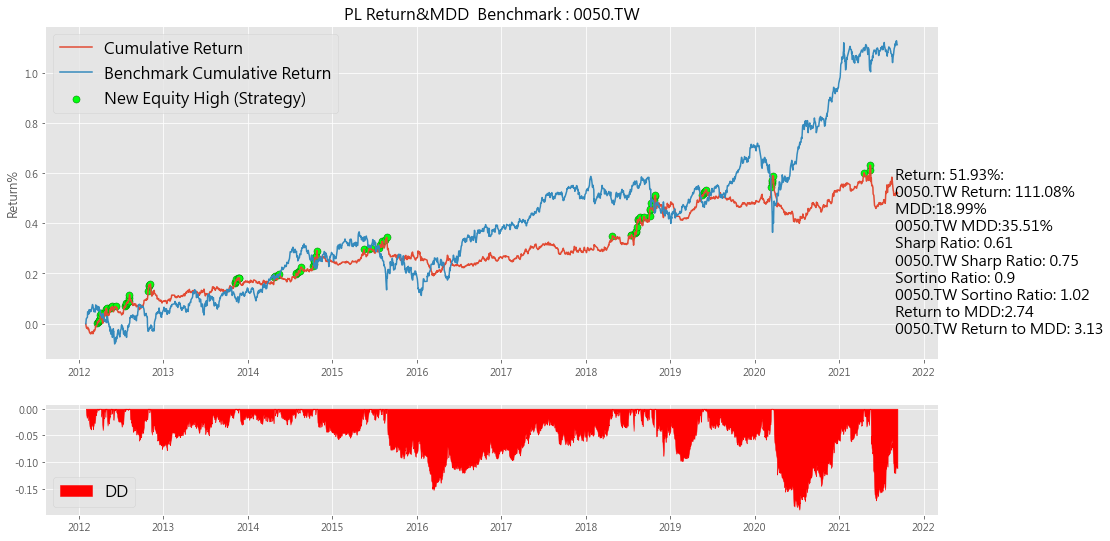

融券維持率low20%/報酬率標準差low20%


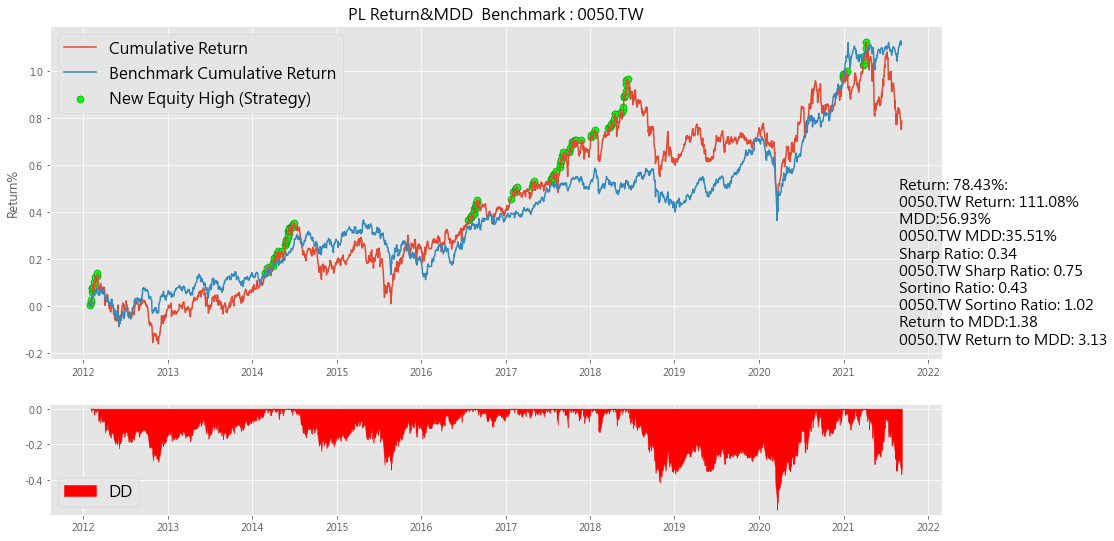

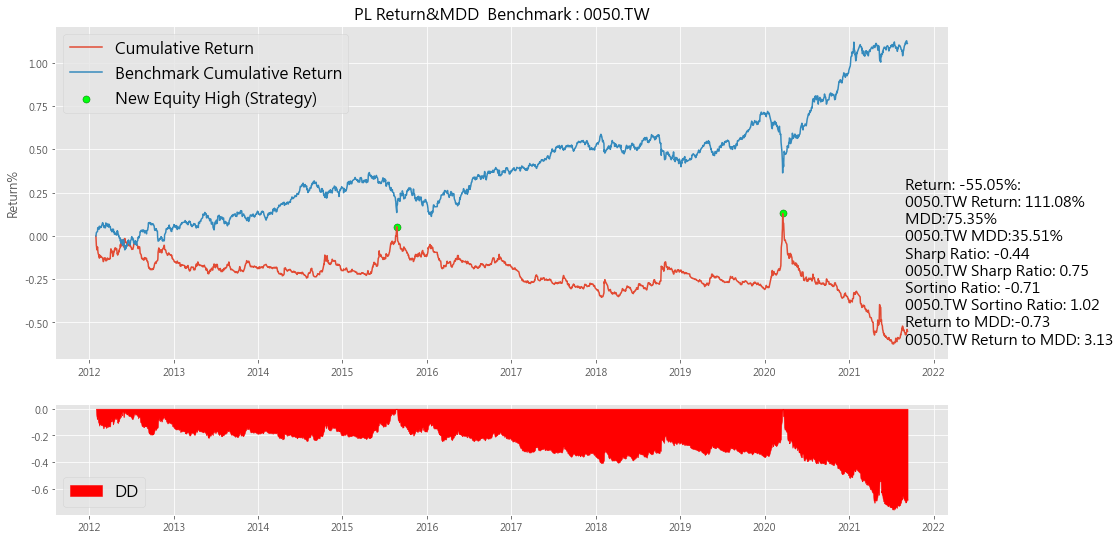

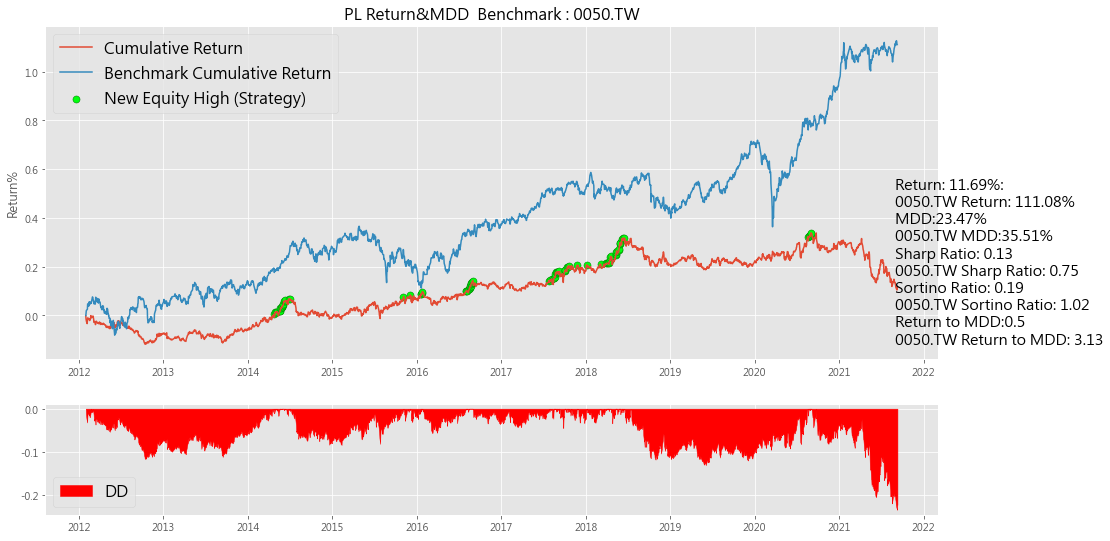

In [33]:
cut_matrix = [[5,1,5,1],
              [5,1,1,5],
             [1,5,1,5],
             [1,5,5,1]]

cut_name = ['融券維持率top20%/報酬率標準差top20%','融券維持率top20%/報酬率標準差low20%','融券維持率low20%/報酬率標準差top20%','融券維持率low20%/報酬率標準差low20%']

portfolio_df = {}
for m in range(0,4) :
    ret_long_list = []
    ret_short_list = []
    tic_long_list = []
    tic_short_list = []
    ret_port_list = []

    long_cut_1 = cut_matrix[m][0]
    short_cut_1 = cut_matrix[m][1]
    
    long_cut_2 = cut_matrix[m][2]
    short_cut_2 = cut_matrix[m][3]
    cut_size = 5
    cost = -0.001425

   

    # data1 = signal_df
    data1 = signal_df
    data2 = ret_pct_df
    # data3 = stock_21day_high

    for i in range(1,len(rebalance_list['start'])) :

        long_signal = stock_multi_signal(rebalance_list['end'][i-1],cut_size,long_cut_1,long_cut_2,data1,data2) & set(market_df.loc[rebalance_list['end'][i-1]][market_df.loc[rebalance_list['end'][i-1]] == 'TSE  '].index)

        short_signal = stock_multi_signal(rebalance_list['end'][i-1],cut_size,short_cut_1,short_cut_2,data1,data2) & set(market_df.loc[rebalance_list['end'][i-1]][market_df.loc[rebalance_list['end'][i-1]] == 'TSE  '].index)

        ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

        tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

        ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

        tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

        if long_signal.values.squeeze() != [] :
            ret_long[0] = cost
            ret_short[0] = cost

        ret_long_list.append(ret_long)
        tic_long_list.append(tic_long)

        ret_short_list.append(ret_short)
        tic_short_list.append(tic_short)

        ret_port_list.append((ret_long+ret_short)/2)

    ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
    tic_long_df = pd.DataFrame(tic_long_list)
    ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
    tic_short_df = pd.DataFrame(tic_short_list)
    ret_port_df = (ret_long_df+ret_short_df)/2

    sharpe = round(ret_long_df.mean()/ret_long_df.std()*(252**(1/2)),2)
    mdd = (ret_long_df.cumsum().cummax()-ret_long_df.cumsum()).max()
    ret_mdd =round((ret_long_df.cumsum().iloc[-1])/mdd,2)

    portfolio_df[cut_name[m]] = [str(round(ret_long_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_short_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_port_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                  sharpe.squeeze(),
                                  str(round(mdd.squeeze(),4)*100) + '%',
                                  ret_mdd.squeeze()]
    print(cut_name[m])
    for i in [ret_long_df,ret_short_df,ret_port_df] :
        equity_plot(i.cumsum(),'0050.TW','PL',1)

In [34]:
multi_factor_df = pd.DataFrame(portfolio_df, index = ['做多','做空(不考慮融券費用&數量)','對沖','Sharpe','MDD','Return To MDD(做多)']).T
multi_factor_df.sort_values(['Return To MDD(做多)'],ascending = False)

做多 做空(不考慮融券費用&數量)  \
融券維持率low20%/報酬率標準差top20%              156.51%        -52.64%   
融券維持率low20%/報酬率標準差low20%               78.43%        -55.05%   
融券維持率top20%/報酬率標準差low20%                6.88%       -126.59%   
融券維持率top20%/報酬率標準差top20%  4.4799999999999995%       -204.68%   

                                           對沖 Sharpe                 MDD  \
融券維持率low20%/報酬率標準差top20%               51.93%   1.55              27.16%   
融券維持率low20%/報酬率標準差low20%  11.690000000000001%   0.34              56.93%   
融券維持率top20%/報酬率標準差low20%              -59.85%   0.05  69.74000000000001%   
融券維持率top20%/報酬率標準差top20%              -100.1%   0.02              89.19%   

                         Return To MDD(做多)  
融券維持率low20%/報酬率標準差top20%              5.76  
融券維持率low20%/報酬率標準差low20%              1.38  
融券維持率top20%/報酬率標準差low20%               0.1  
融券維持率top20%/報酬率標準差top20%              0.05

產業回測

In [40]:
industry_list = []
for i in industry_df.TSE新產業_名稱.unique() :
    if len(industry_df[industry_df['TSE新產業_名稱'] == i]) >= 70 :
        print(i,'總上市公司數 : ',len(industry_df[industry_df['TSE新產業_名稱'] == i]))
        industry_list.append(i)

建材營造   總上市公司數 :  77
其他       總上市公司數 :  134
電子零組件 總上市公司數 :  206
電機機械   總上市公司數 :  92
生技醫療   總上市公司數 :  126
電腦及週邊 總上市公司數 :  108
半導體     總上市公司數 :  163
其他電子業 總上市公司數 :  84
通信網路業 總上市公司數 :  89
光電業     總上市公司數 :  118


In [41]:
industry_set = set(stock_set) & set(industry_df[industry_df['TSE新產業_名稱'] == "電子通路業"].公司簡稱.values)

產業別 :  建材營造  


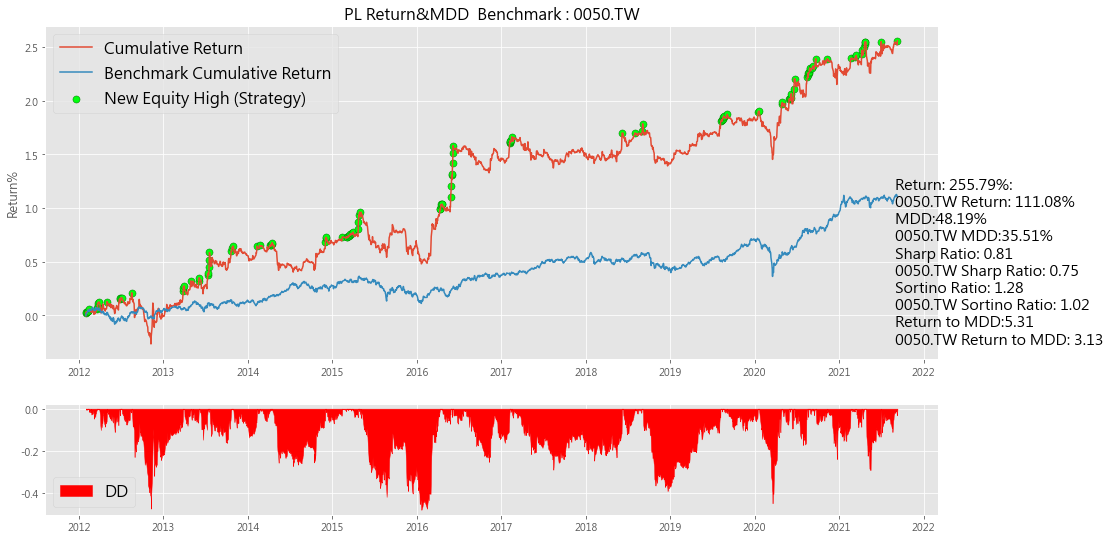

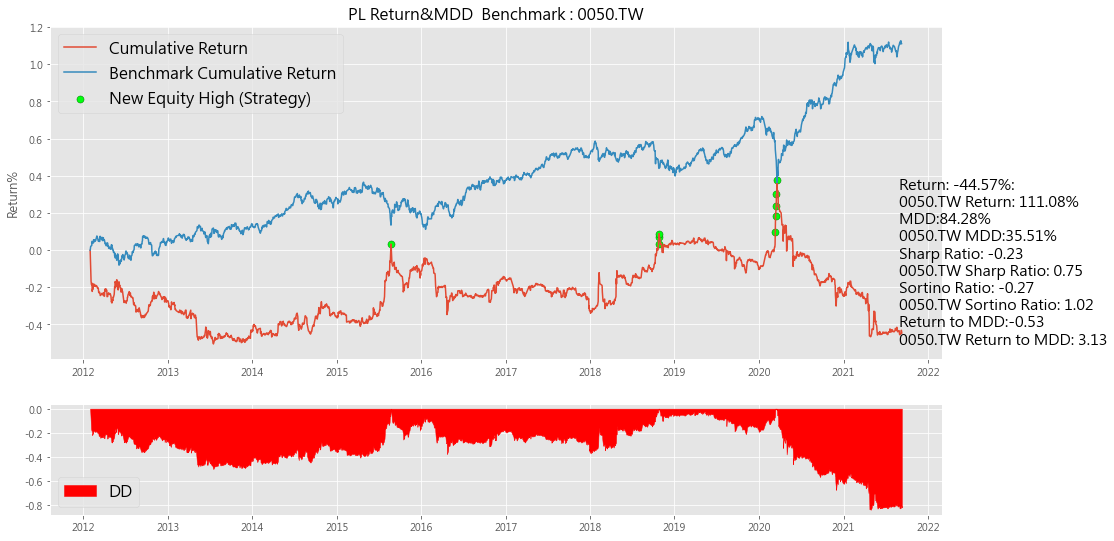

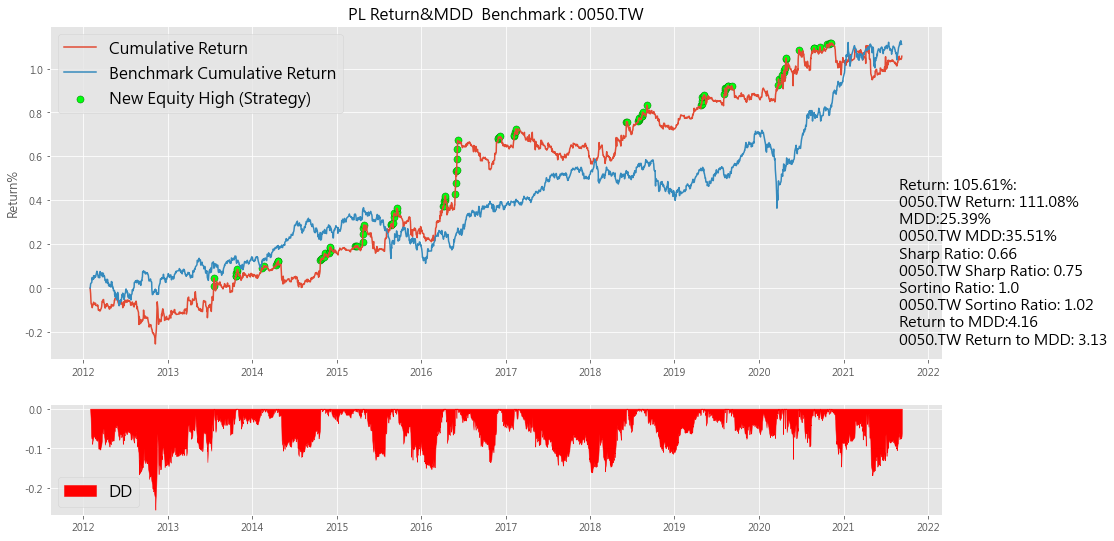

產業別 :  其他      


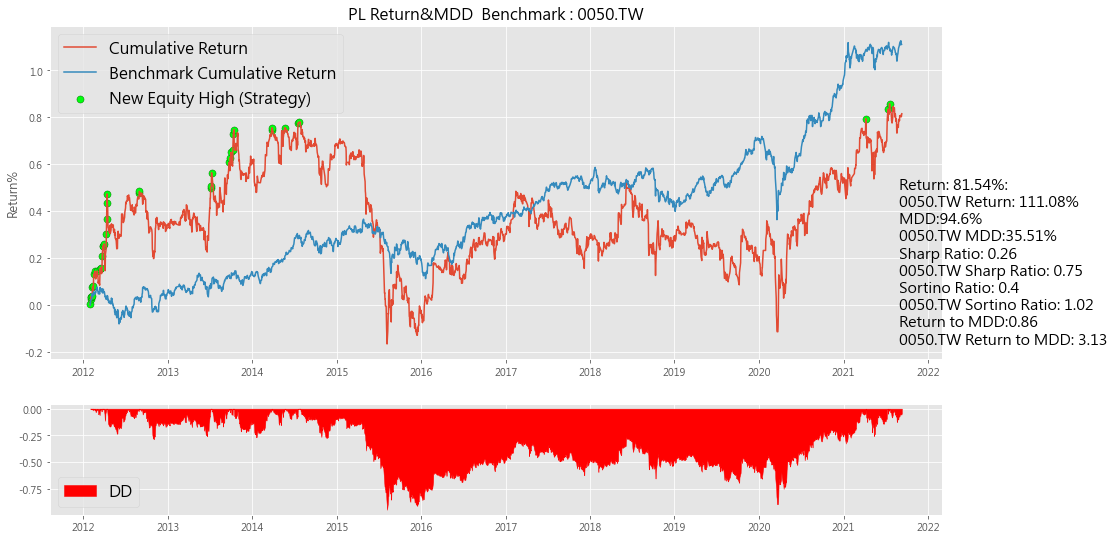

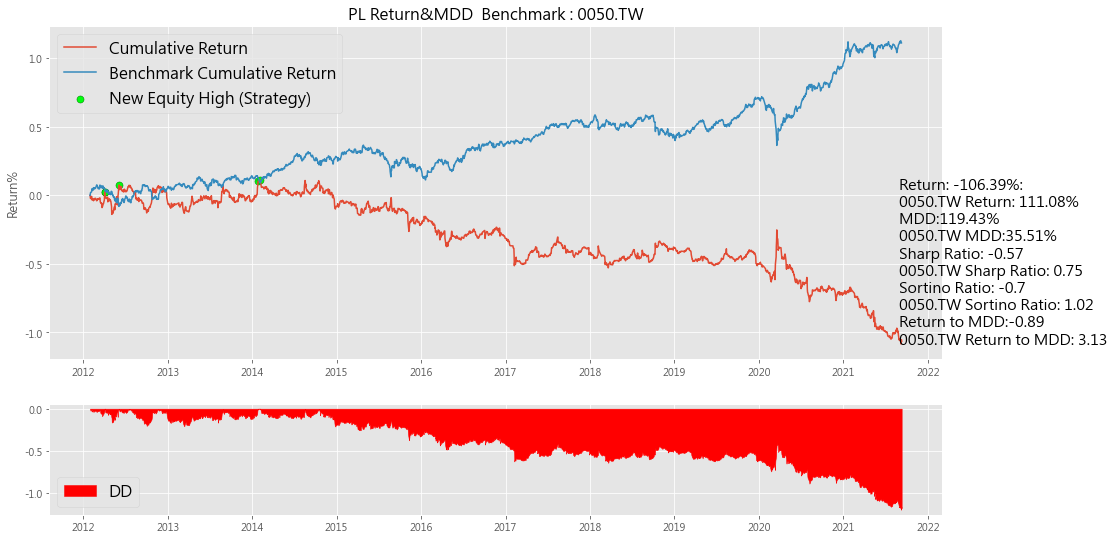

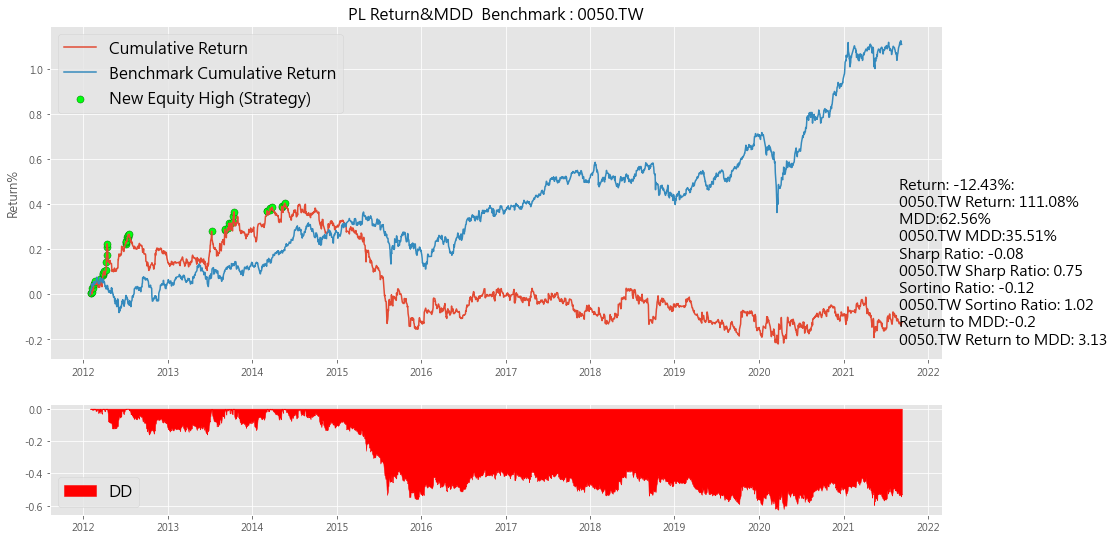

產業別 :  電子零組件


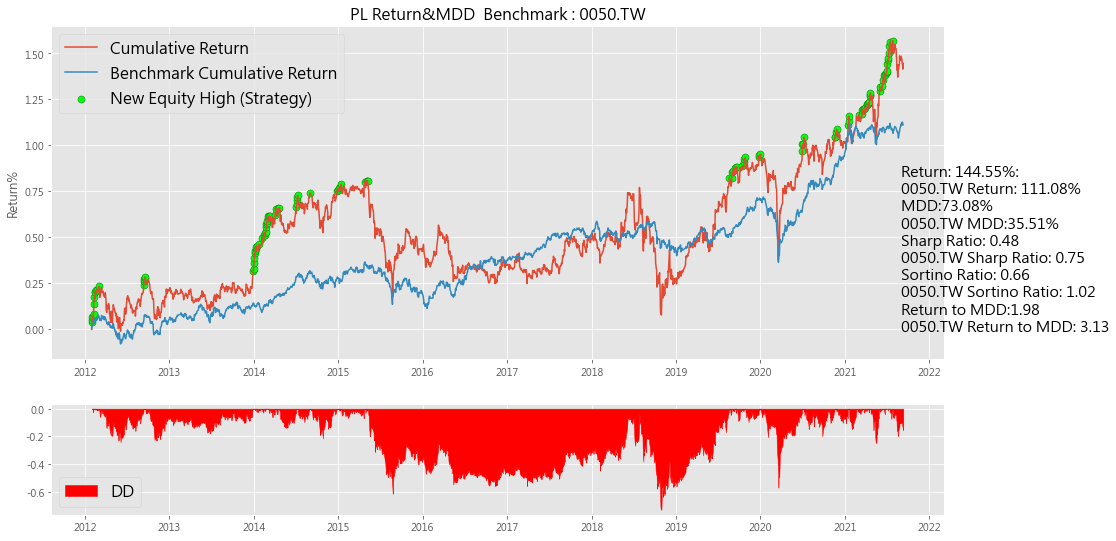

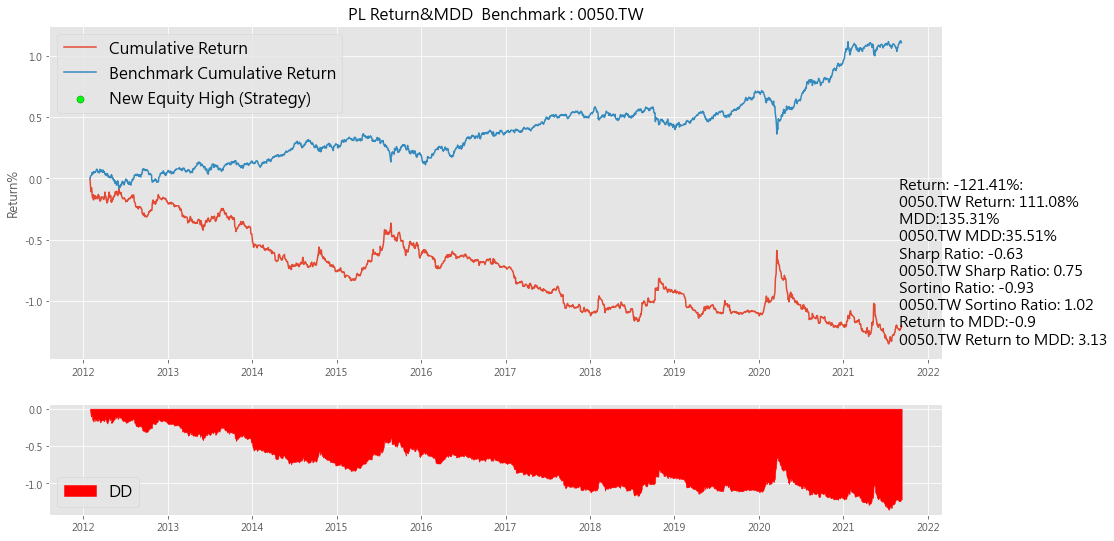

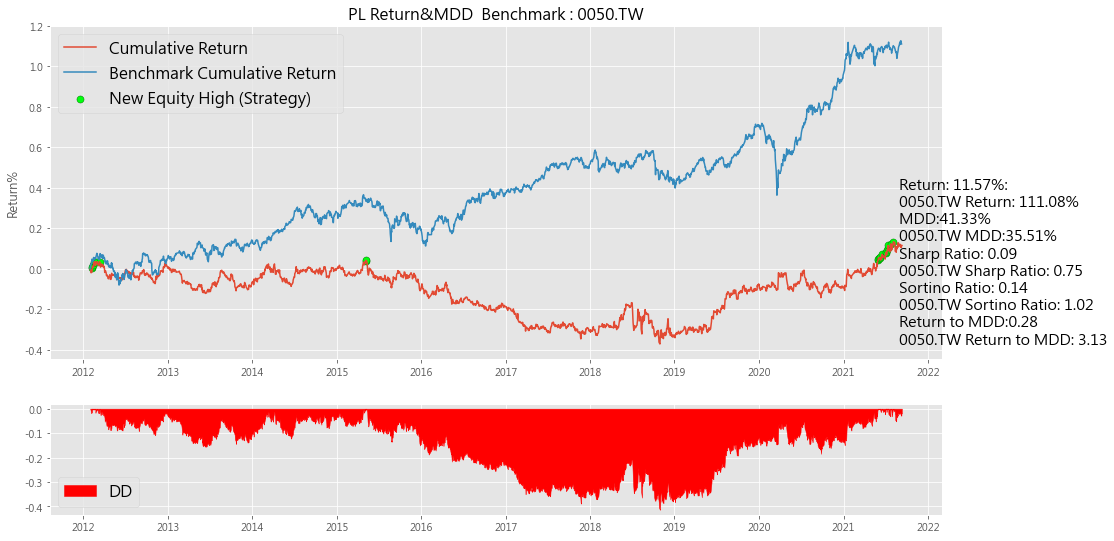

產業別 :  電機機械  


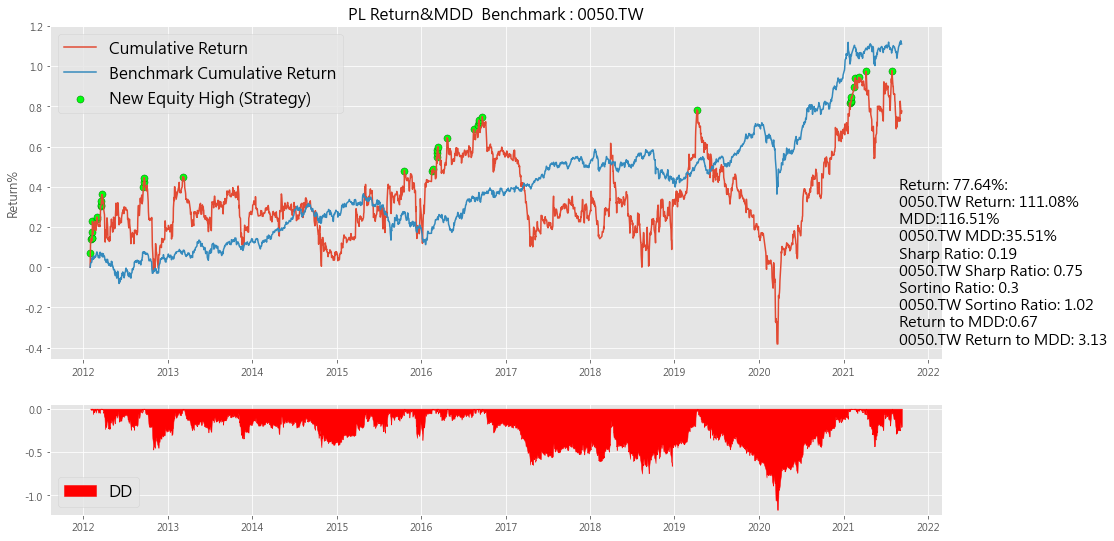

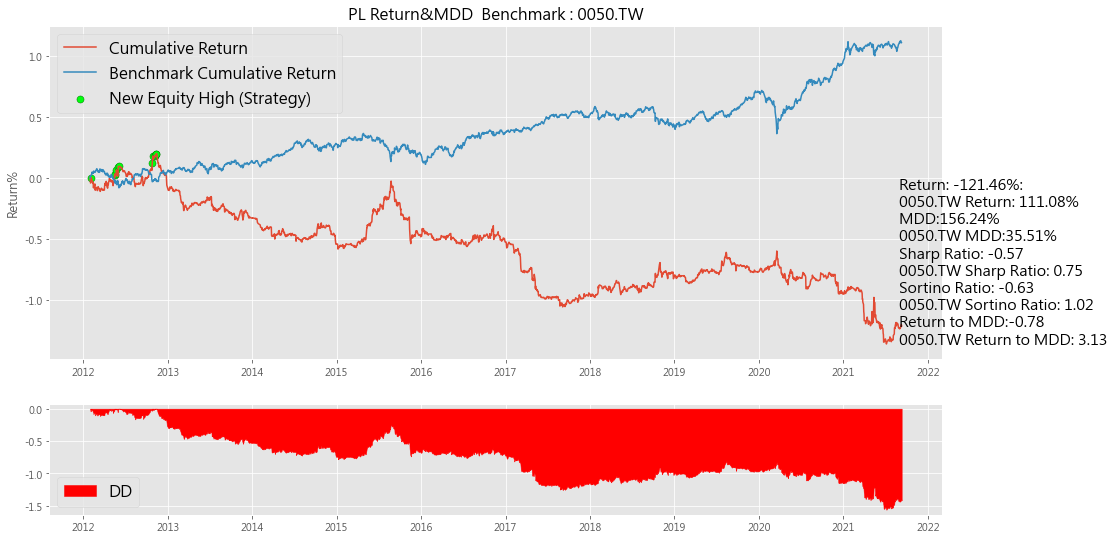

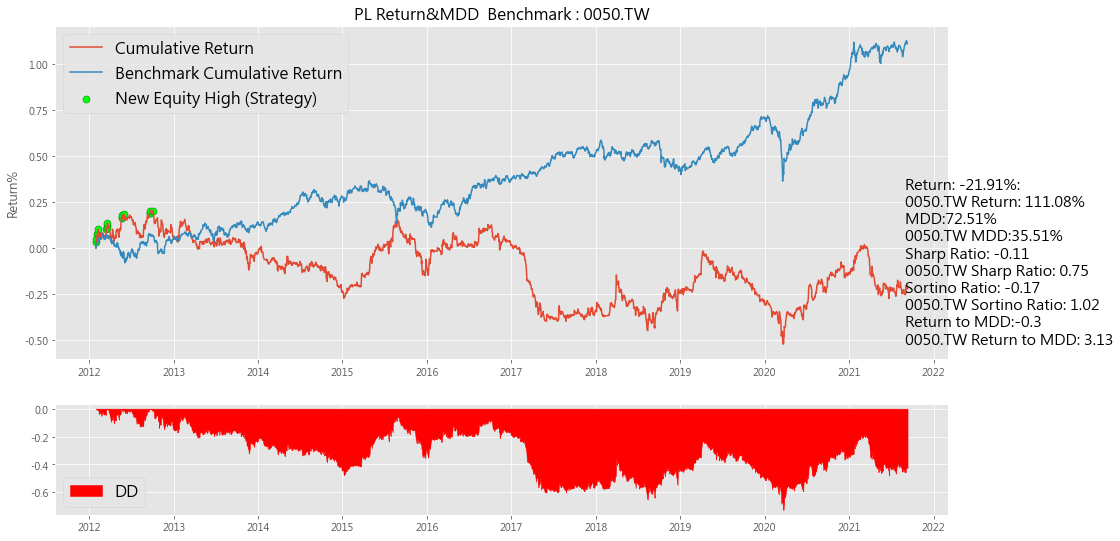

產業別 :  生技醫療  


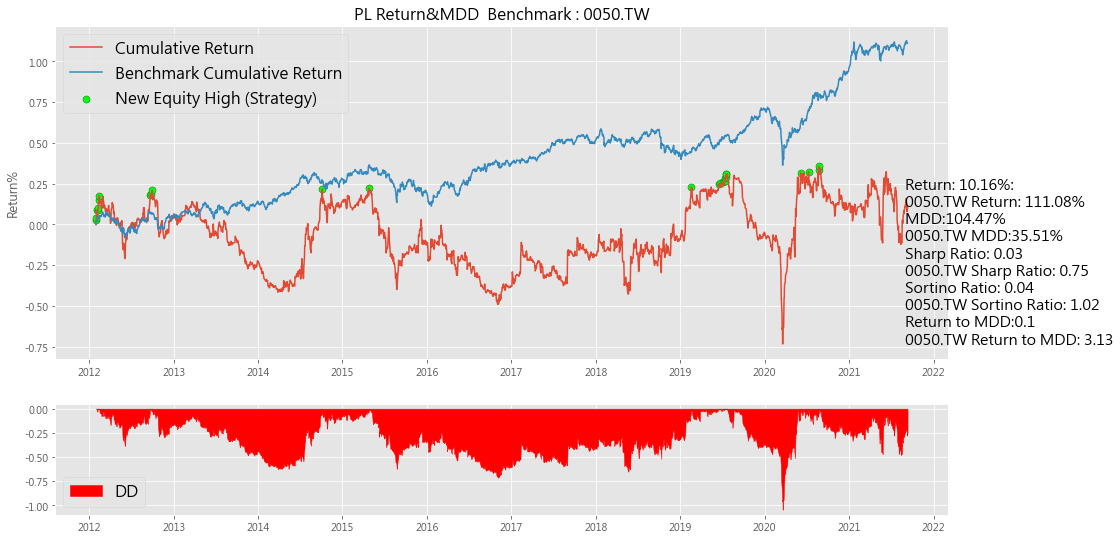

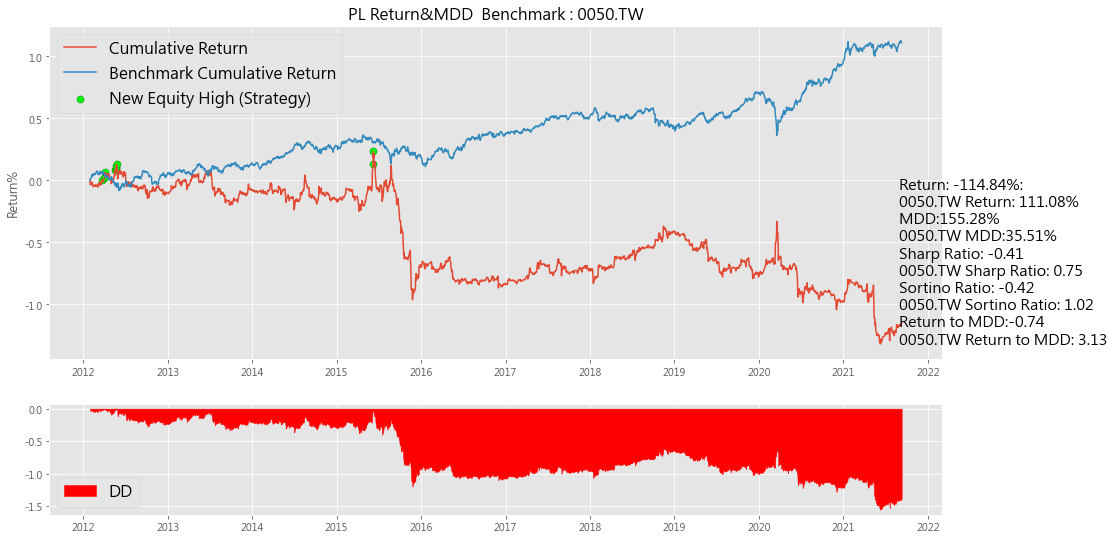

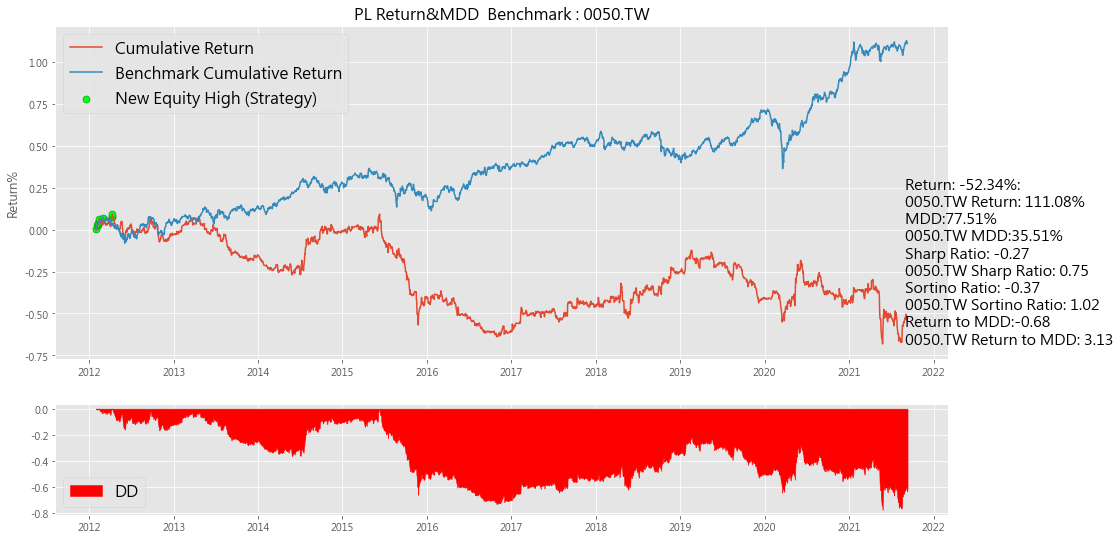

產業別 :  電腦及週邊


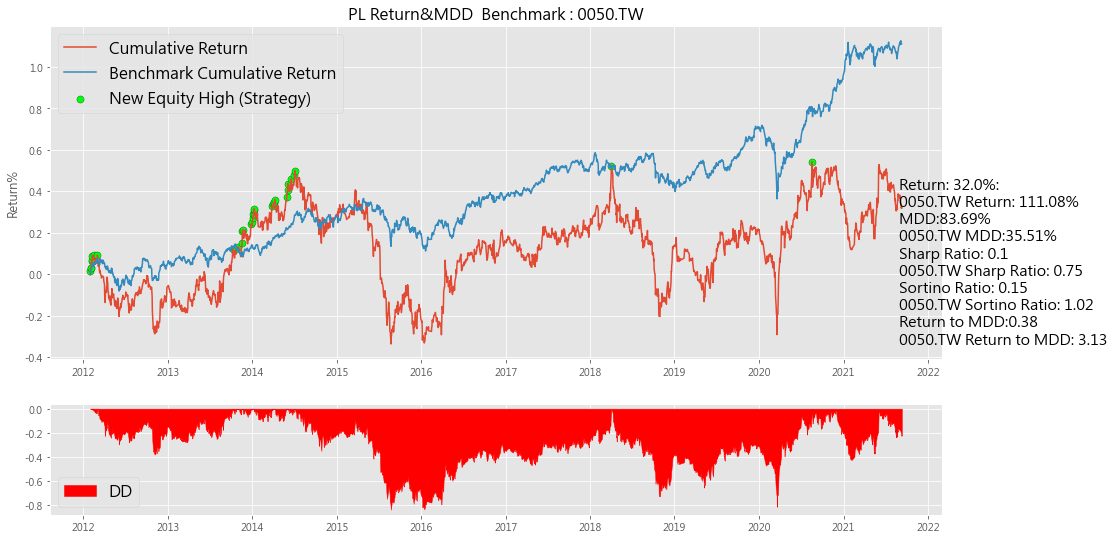

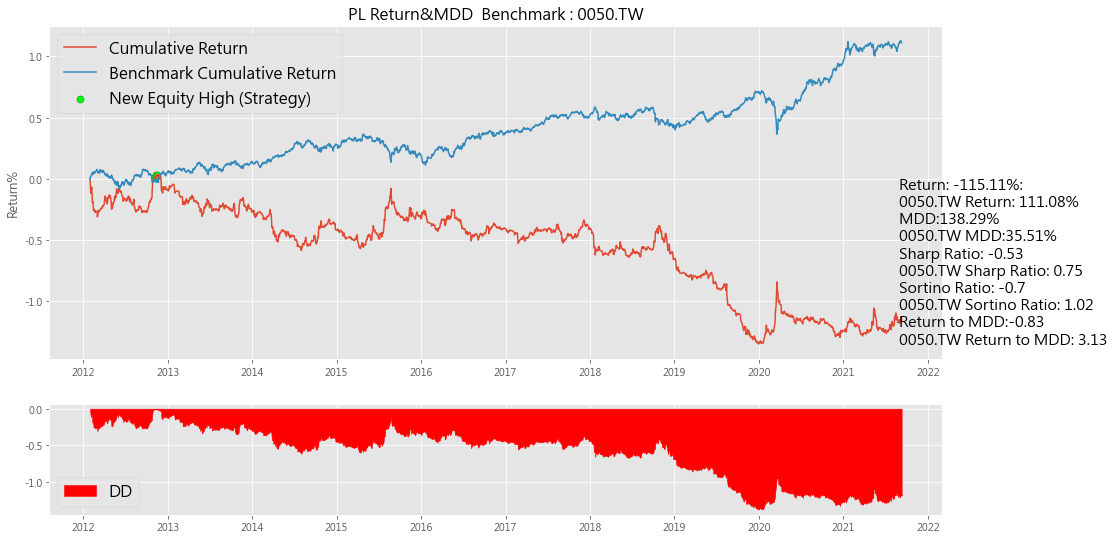

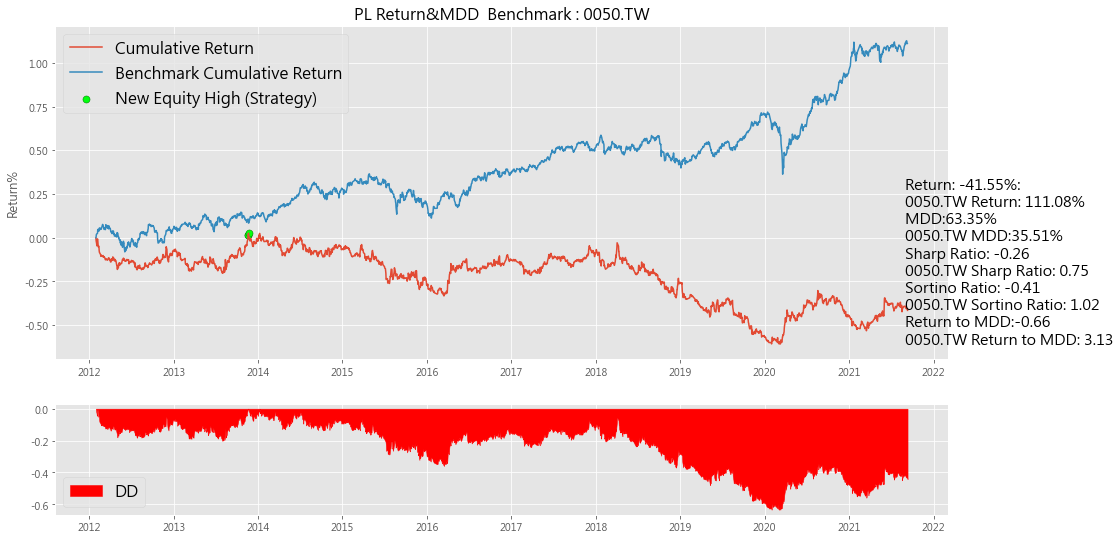

產業別 :  半導體    


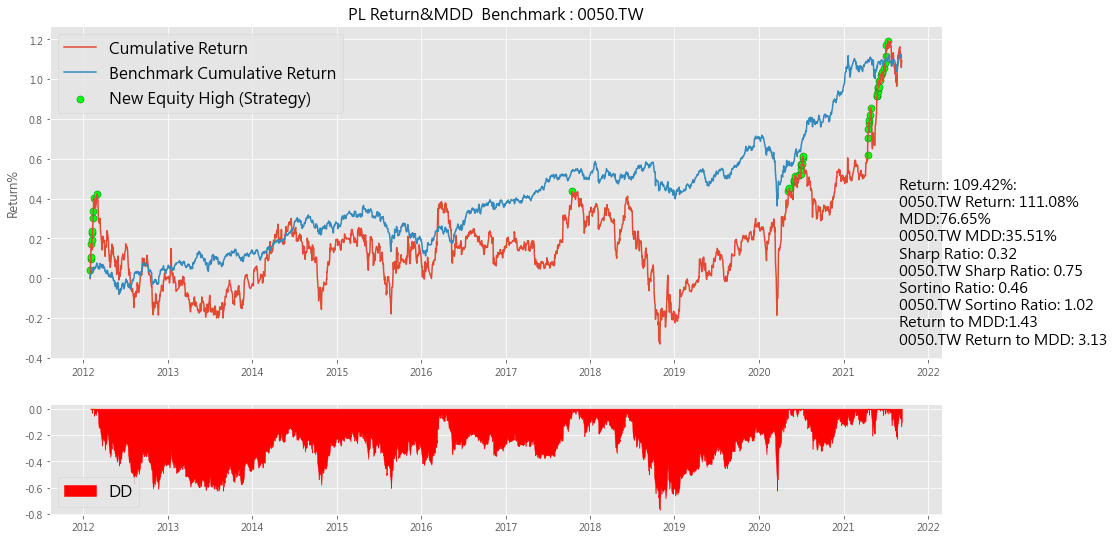

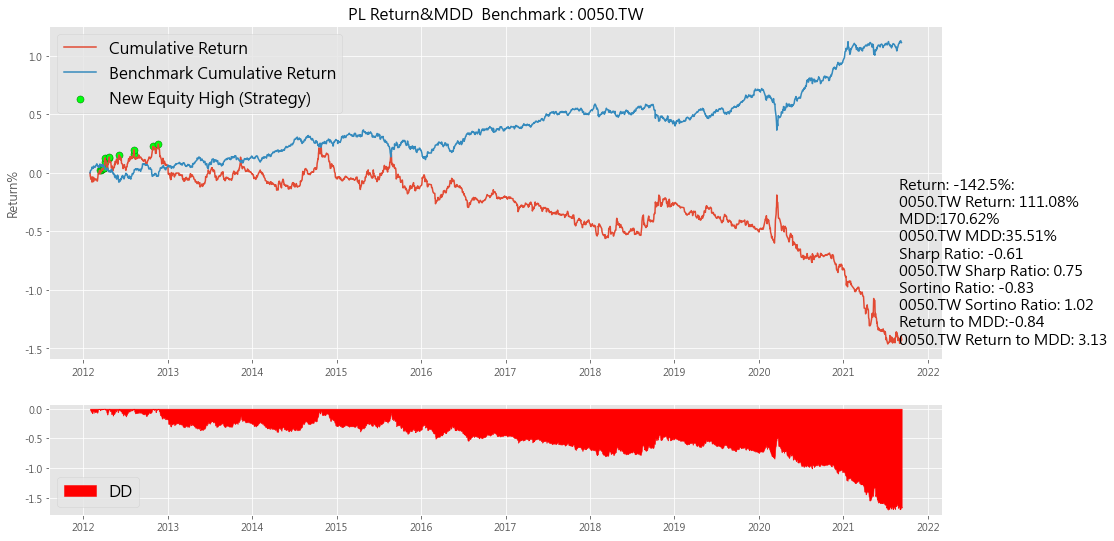

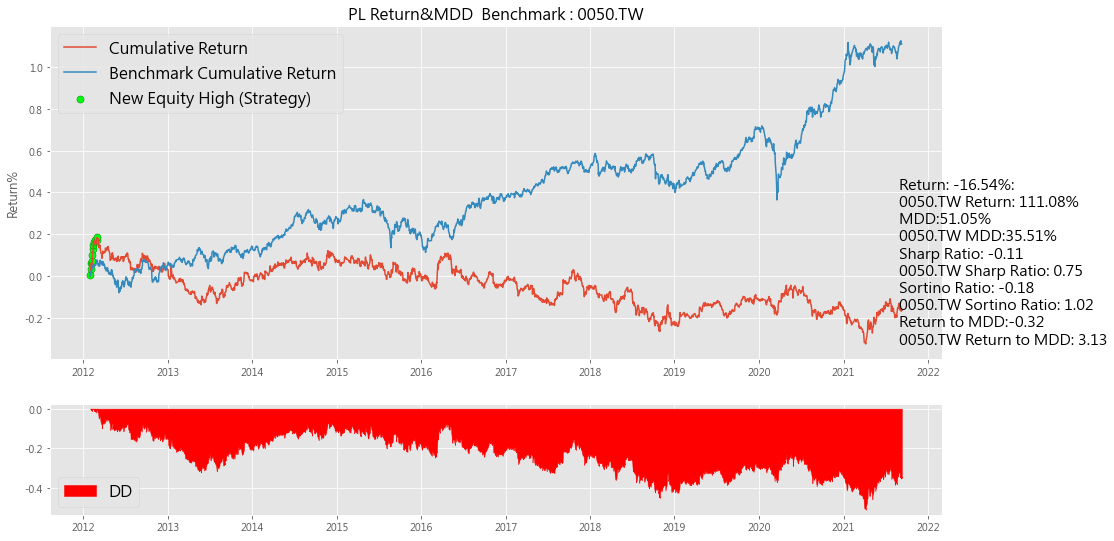

產業別 :  其他電子業


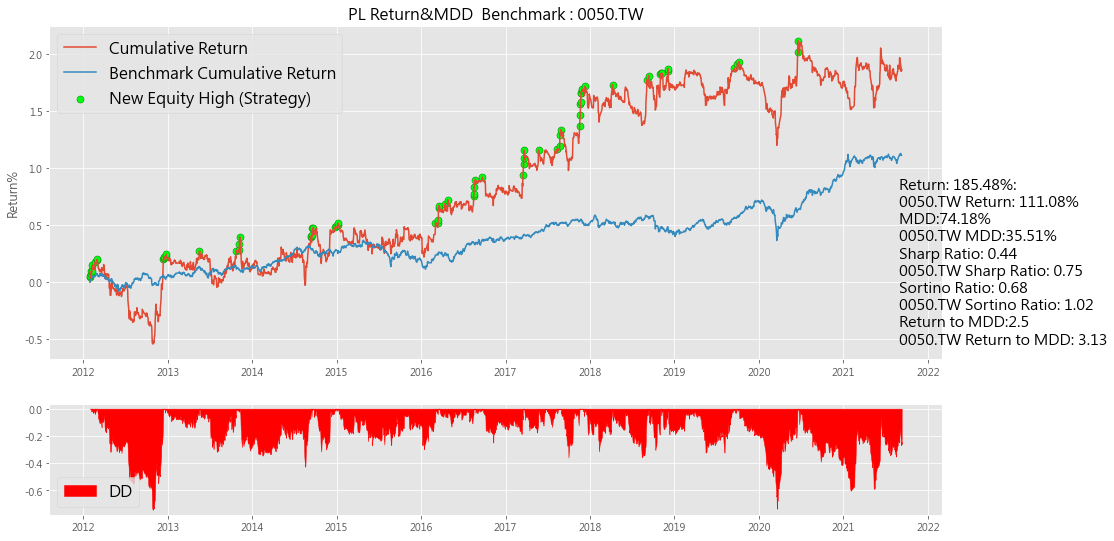

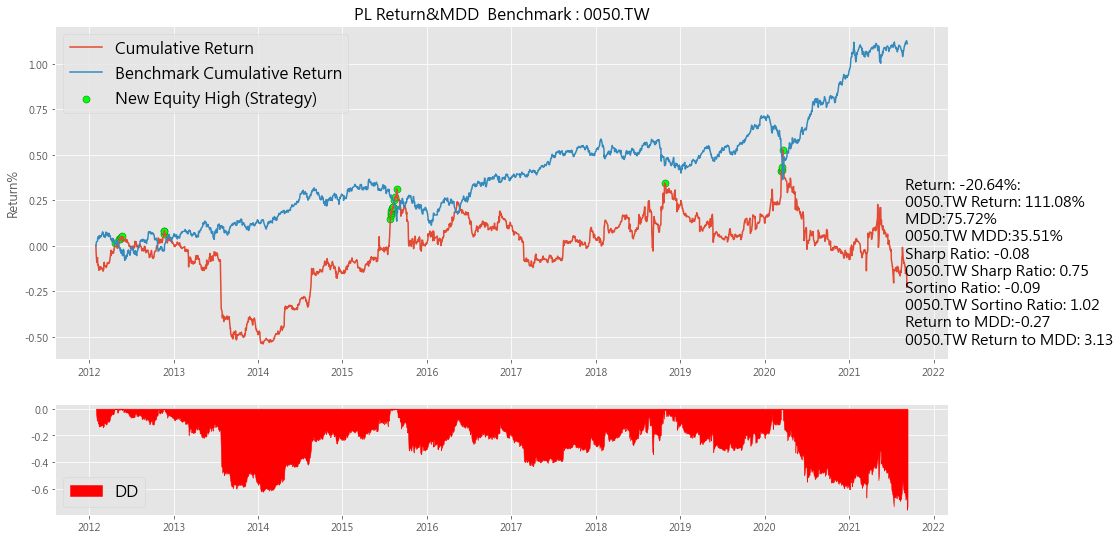

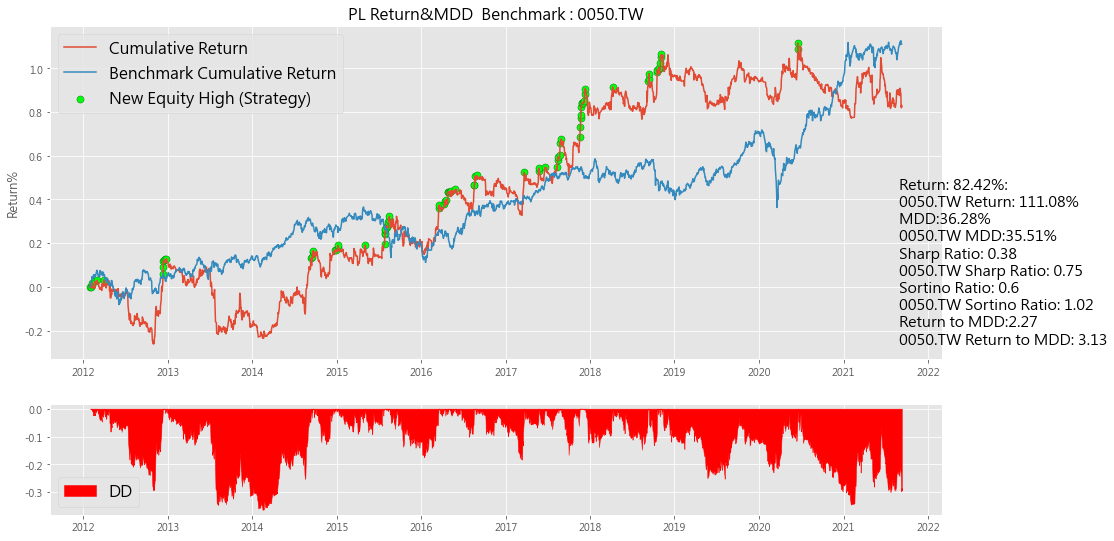

產業別 :  通信網路業


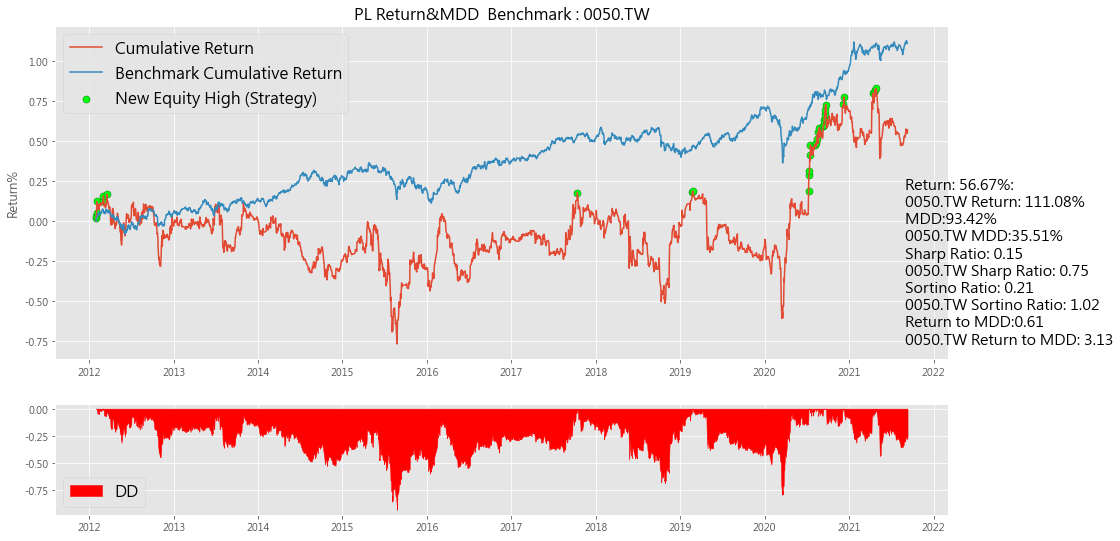

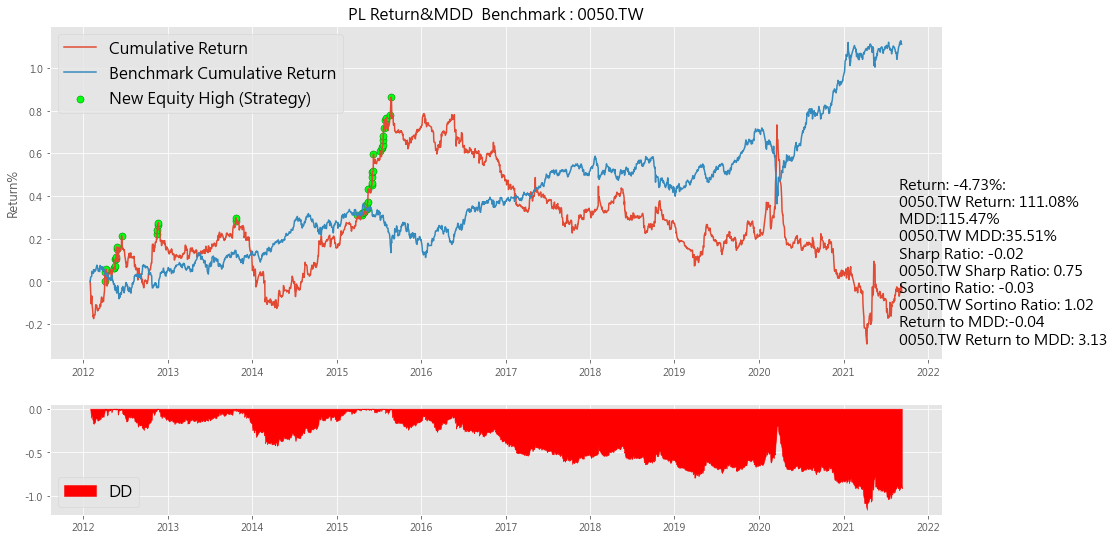

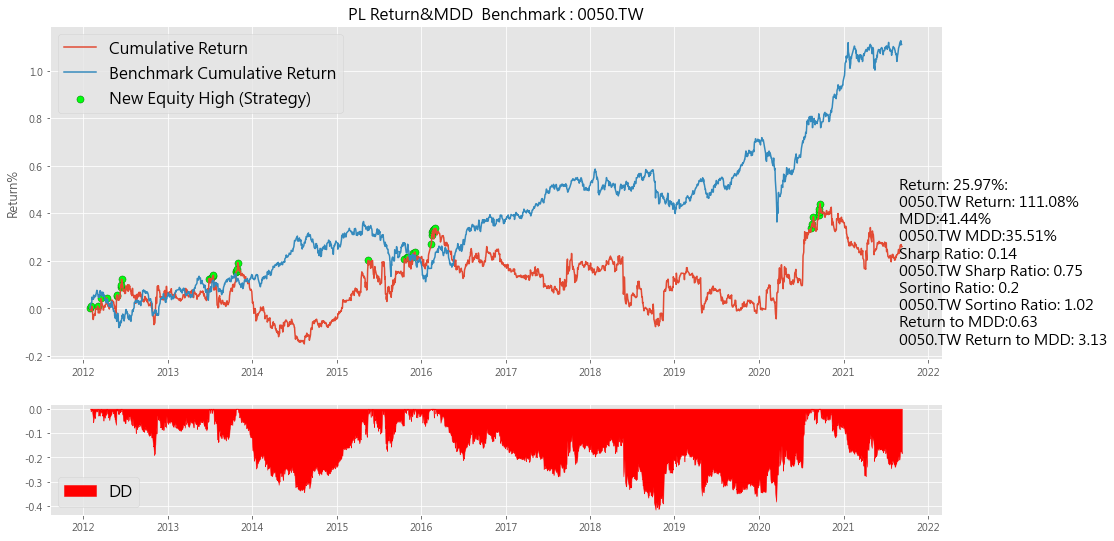

產業別 :  光電業    


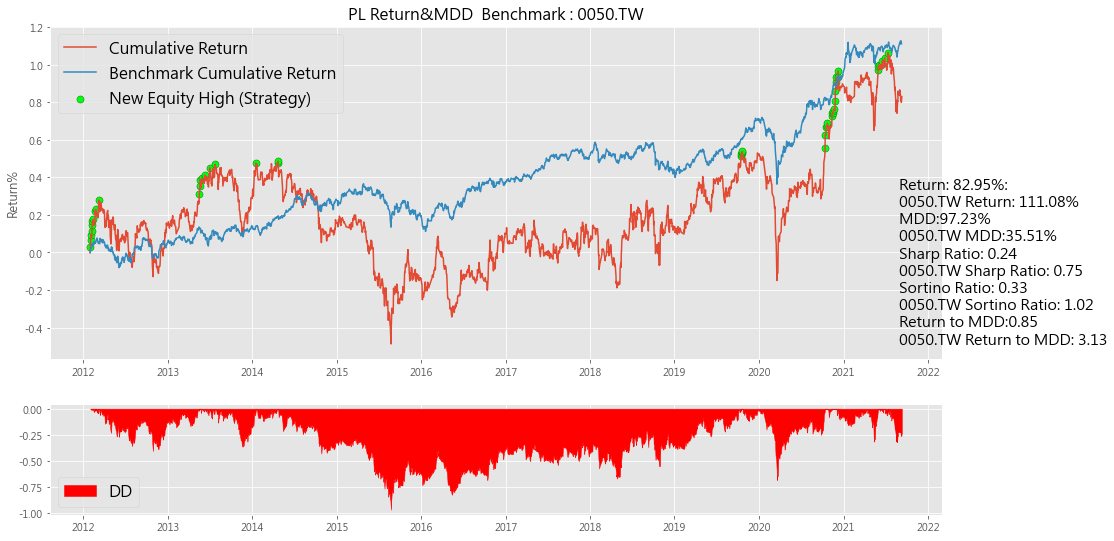

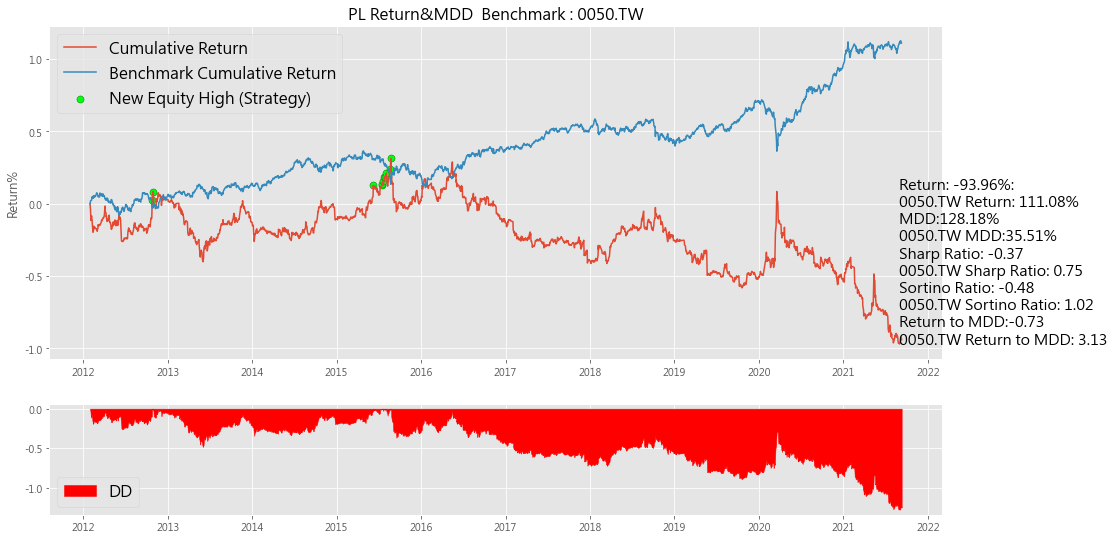

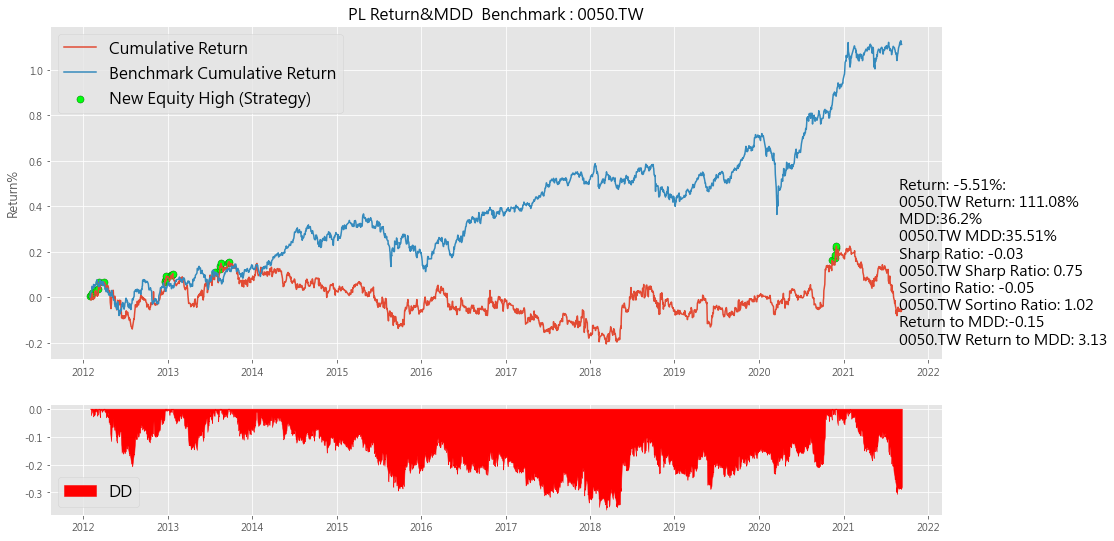

此次回測花費 96.85939002037048 秒


In [75]:
industry_ret_list = {}
industry_short_icir = {}
industry_long_icir = {}
start_time = time.time()
for industry in industry_list :  
    
    industry_set = set(stock_set) & set(industry_df[industry_df['TSE新產業_名稱'] == industry].公司簡稱.values)
    
    ret_long_list = []
    ret_short_list = []
    tic_long_list = []
    tic_short_list = []
    ret_port_list = []
    long_ic_list = []
    short_ic_list = []

    long_cut_1 = 1
    short_cut_1 = 5
    long_cut_2 = 5
    short_cut_2 = 1

#     data1 = lend_df[industry_set]
    data2 = ret_pct_df     
#     long_cut = 5
#     short_cut = 1
    cut_size = 5
    cost = -0.001425

    data1 = signal_df[industry_set]
    # data1 = lend_df
    # data2 = stock_df
    # data3 = stock_21day_high

    
    for i in range(1,len(rebalance_list['start'])) :
        
        if (data1.loc[rebalance_list['end'][i-1]] != 0).sum() < cut_size :
            next
        
        else :
            
        #     訊號
#             long_signal = stock_signal_industry(rebalance_list['end'][i-1],industry_set,cut_size,long_cut_1,data1)
# 
#             short_signal = stock_signal_industry(rebalance_list['end'][i-1],industry_set,cut_size,short_cut_1,data1) 
            
            long_signal = stock_multi_signal_industry(rebalance_list['end'][i-1],industry_set,cut_size,long_cut_1,long_cut_2,data1,data2)
            short_signal = stock_multi_signal_industry(rebalance_list['end'][i-1],industry_set,cut_size,short_cut_1,short_cut_2,data1,data2)
            
            if long_signal.values.squeeze() != [] :
            #     回測
                ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

                tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

                ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

                tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

                ret_long[0] = cost
                ret_short[0] = cost
                
            else :
                ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

                tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

                ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

                tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

                
            ret_long_list.append(ret_long)
            tic_long_list.append(tic_long)

            ret_short_list.append(ret_short)
            tic_short_list.append(tic_short)

            ret_port_list.append((ret_long+ret_short)/2)
    
    ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
    tic_long_df = pd.DataFrame(tic_long_list)
    ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
    tic_short_df = pd.DataFrame(tic_short_list)
    ret_port_df = (ret_long_df+ret_short_df)/2
    
    sharpe = round(ret_long_df.mean()/ret_long_df.std()*(252**(1/2)),2)
    mdd = (ret_long_df.cumsum().cummax()-ret_long_df.cumsum()).max()
    ret_mdd =round((ret_long_df.cumsum().iloc[-1])/mdd,2)
    
    industry_ret_list[industry] = [str(round(ret_long_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_short_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_port_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                  sharpe.squeeze(),
                                  str(round(mdd.squeeze(),4)*100) + '%',
                                  ret_mdd.squeeze()]
    
    print("產業別 : ", industry)
    
    for i in [ret_long_df,ret_short_df,ret_port_df] :
        equity_plot(i.cumsum(),'0050.TW','PL',1)

end_time = time.time()
print('此次回測花費 %s 秒' %(end_time-start_time))

In [77]:
industy_ret_df = pd.DataFrame(industry_ret_list, index = ['做多','做空(不考慮融券費用&數量)','對沖','Sharpe','MDD','Return To MDD(做多)']).T
industy_ret_df.sort_values(['Return To MDD(做多)'],ascending = False)

做多 做空(不考慮融券費用&數量)                    對沖 Sharpe  \
建材營造      255.79000000000002%        -44.57%               105.61%   0.81   
其他電子業                 185.48%        -20.64%                82.42%   0.44   
電子零組件                 144.55%       -121.41%                11.57%   0.48   
半導體                   109.42%        -142.5%               -16.54%   0.32   
其他                     81.54%       -106.39%               -12.43%   0.26   
光電業                    82.95%        -93.96%   -5.510000000000001%   0.23   
電機機械                   77.64%       -121.46%               -21.91%   0.19   
通信網路業                  56.67%         -4.73%                25.97%   0.15   
電腦及週邊                   32.0%       -115.11%               -41.55%    0.1   
生技醫療                   10.16%       -114.84%  -52.339999999999996%   0.03   

                         MDD Return To MDD(做多)  
建材營造                  48.19%              5.31  
其他電子業                 74.18%               2.5  
電子零組件                 73.08%              1.98  
半導體       76.64999999999999%              1.43  
其他                     94.6%              0.86  
光電業                   97.23%              0.85  
電機機械                 116.51%              0.67  
通信網路業                 93.42%              0.61  
電腦及週邊                 83.69%              0.38  
生技醫療                 104.47%               0.1